**Set up notebook:**

In [1]:
import sys
sys.path.append('../')
sys.path.append('../library/')
sys.path.append('../library/LogPai/')
sys.path.append('../Dataset/')

In [2]:
#Import required libraries for this notebook

from library.malib import *
import pandas as pd
# from datetime import datetime
# from sklearn.preprocessing import MinMaxScaler
# import numpy as np
# from keras.models import Sequential
# from keras.models import model_from_json, load_model
# from keras.layers import Dense, Dropout
# from keras.layers import LSTM, Input
# from keras.callbacks import EarlyStopping
# import matplotlib.pyplot as plt
# from google.colab import files
# import seaborn as sns
# from sklearn.linear_model import LinearRegression
# import re

pd.set_option('display.max_rows', 200)

**Load dataset:**

In [3]:
data_folder = '~/MA/Dataset/'

In [4]:
#Read WTG data
signals_train = 'wind-farm-1-signals-training.csv'
signals_test = 'wind-farm-1-signals-testing.csv'
all_data = load_data(data_folder=data_folder, file_name_1=signals_train, file_name_2=signals_test, time_index_column='Timestamp', delimeter=';')

#Read log data
logs_2016 = 'wind-farm-1-logs-2016.csv'
logs_2017 = 'wind-farm-1-logs-2017.csv'
log_data = load_data(data_folder=data_folder, file_name_1=logs_2016, file_name_2=logs_2017, time_index_column='TimeDetected', delimeter=';')
log_data = log_data.loc[log_data.index.notnull()]

#Target/Test turbine: Filter T_09 data out
T06_data = all_data[all_data.Turbine_ID == 'T06']
log_data_T06 = log_data[log_data['UnitTitle'] == 'T06']

#Remove duplicates in Timestamp index: Usually occurs at daylight saving
T06_data = T06_data[~T06_data.index.duplicated(keep='first')]
log_data_T06 = log_data_T06[~log_data_T06.index.duplicated(keep='first')]

**Extract log feature manually:**

In [5]:
feat_names_T06, log_feat_T06 = get_log_features(log_data_T06[~log_data_T06.index.duplicated(keep='first')], 'Remark', 'vent\.')

/Users/backupuser/MA/Notebooks/../library/malib.py:259: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  feats = feats[log_msg_column].str.rsplit('.', 1, expand=True).rename(columns = {0 : 'name', 1 : 'value'})


**Extract log feature automatically using logpai:**

In [6]:
#logpai-parsed log features
input_dir  = '~/MA/library/LogPai/logparser/logs/SCADA/' # The input directory of log file
output_dir = input_dir # The output directory of parsing results
log_file   = 'logs.txt' # The input log file name
log_format = '<TimeDetected>,<TimeReset>,<UnitTitle>,<Content>,<UnitTitleDestination>' # SCADA log format

logpai_feats_events_T06 = get_log_pai_feats('T06', 'EventId', data_folder_input=input_dir, data_folder_output=output_dir, 
log_file_name=log_file, log_format=log_format)
# logpai_feats_parameters_T06 = get_log_pai_feats('T06', 'ParameterList', data_folder_input=input_dir, data_folder_output=output_dir, 
# log_file_name=log_file, log_format=log_format)

/Users/backupuser/MA/Notebooks/../library/malib.py:326: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv(data_folder + file_name_1, delimiter=delimeter)


====== Transformed train data summary ======
Train data shape: 55699-by-16



**Append log features to signals:**

In [7]:
#Manual logs
T06_data_logs = pd.merge_asof(T06_data, log_feat_T06, left_index = True, right_index = True, tolerance = pd.Timedelta('10m')).fillna(method='ffill').fillna(method='bfill')

#LogPai logs
T06_data_logs = pd.merge_asof(T06_data_logs, logpai_feats_events_T06, left_index = True, right_index = True, tolerance = pd.Timedelta('10m')).fillna(method='ffill').fillna(method='bfill')

**EDA...**

In [8]:
#Selected features
target_features = ['Gen_Phase1_Temp_Avg']
features_wout_logs = ['Nac_Temp_Avg', 'Amb_Temp_Avg', 'Gen_RPM_Avg', 'Prod_LatestAvg_TotActPwr'] + target_features
features_w_logs = features_wout_logs + feat_names_T06
features_w_logs_logpai = features_wout_logs + list(logpai_feats_events_T06.columns)
target_feature = 'Gen_Phase1_Temp_Avg'

#Train/Test Periods
train_start_T06 = '2016-07-22'
train_end_T06 = '2016-09-15'
test_start_T06 = '2016-09-16'
test_end_T06 = '2016-10-18'

T06_data_logs.loc[train_start_T06 : train_end_T06, 'dataset'] = 'Train'
T06_data_logs.loc[test_start_T06 : test_end_T06, 'dataset'] = 'Test'

Distribution of Features (T06)

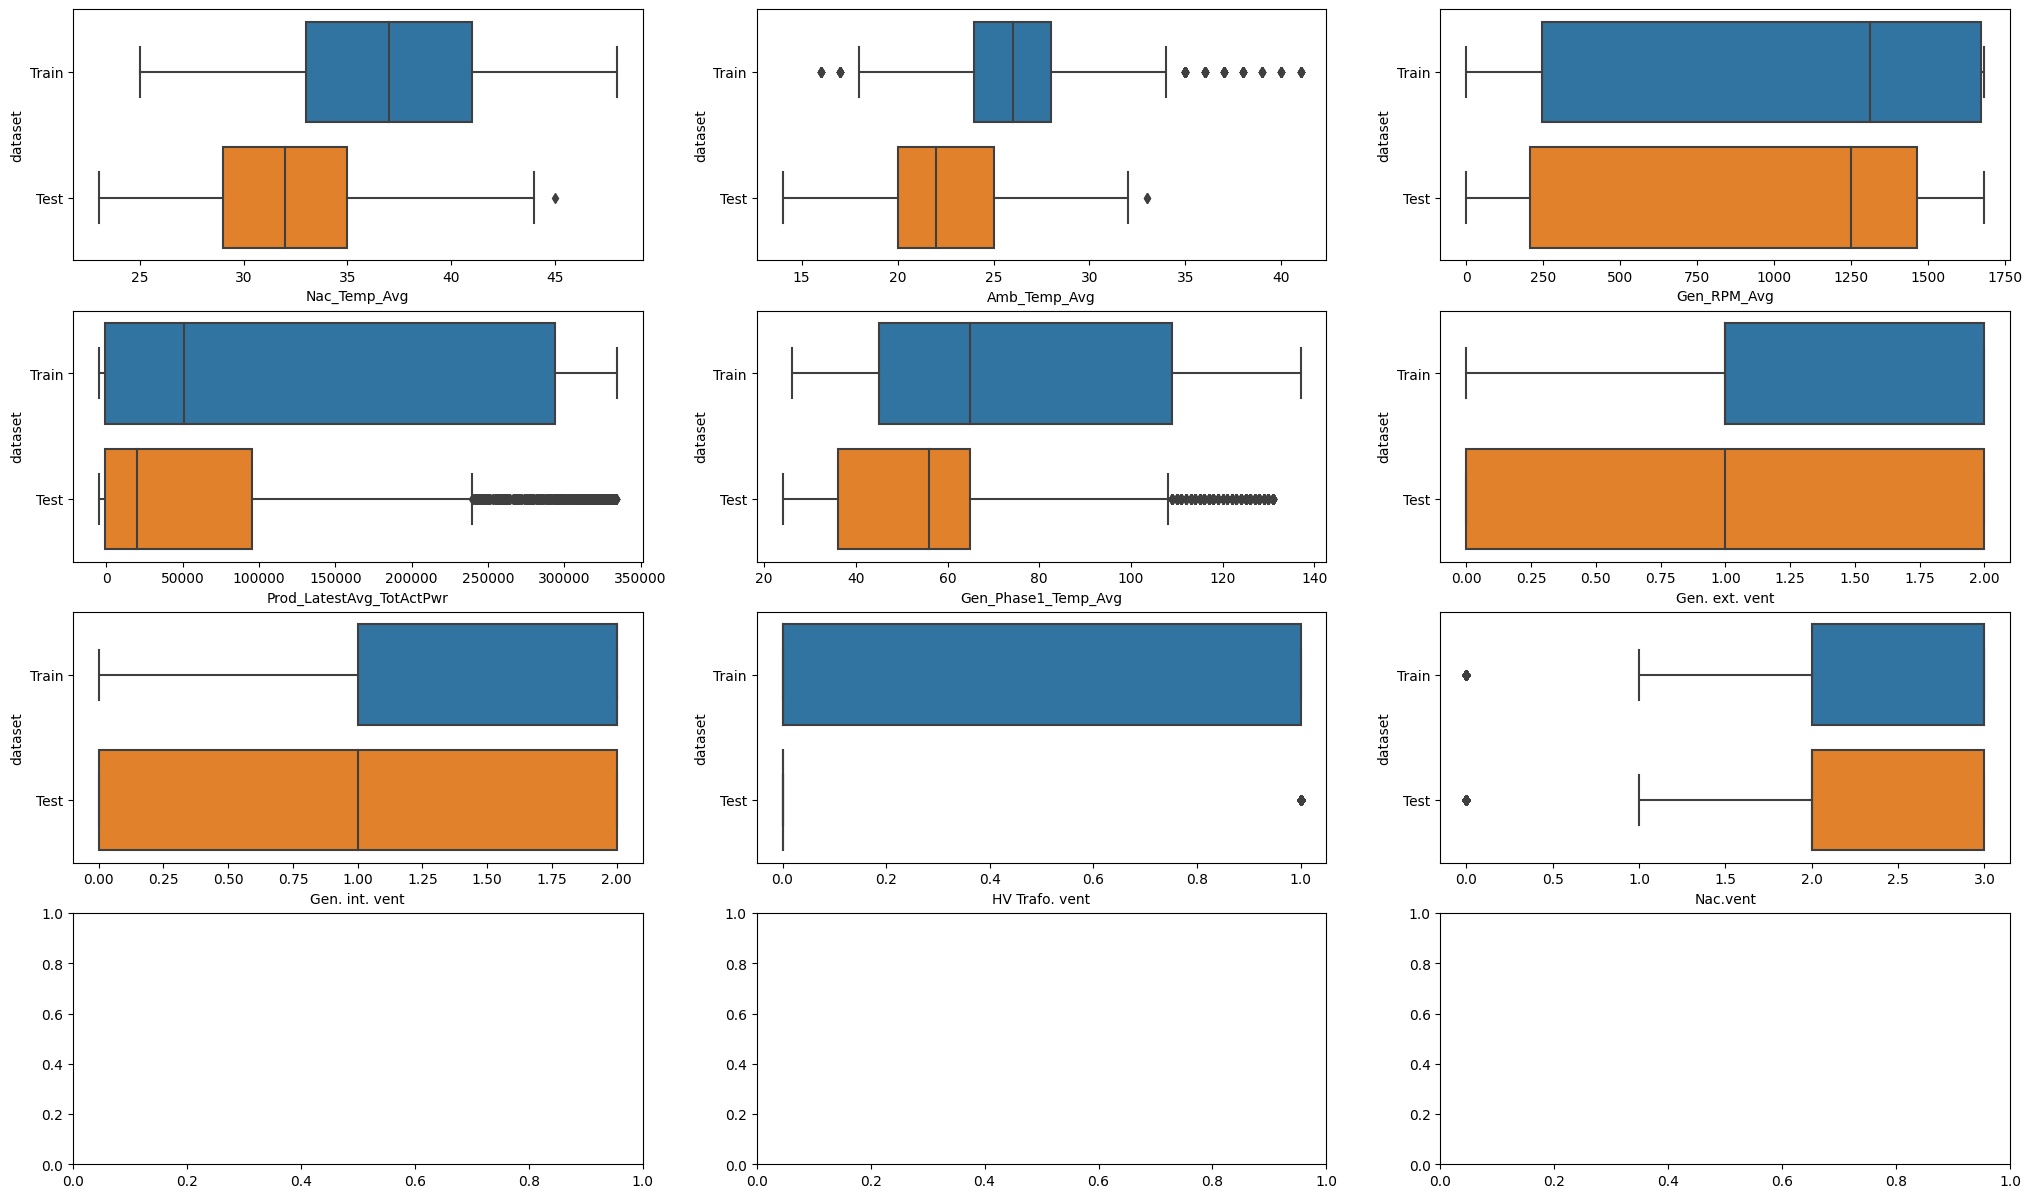

In [9]:
%matplotlib inline
fig, axes = plt.subplots((len(features_w_logs)//3) + 1, 3, figsize=(25,15))
for (i, feature) in zip(range(len(features_w_logs)), features_w_logs):
  sns.boxplot(data = T06_data_logs, x=feature, y='dataset', ax=axes[i//3][i%3])

**Baseline using Linear Regression**

In [10]:
# features = ['Amb_WindSpeed_Avg', 'Cont_Top_Temp_Avg', 'Cont_VCP_ChokcoilTemp_Avg', 'Cont_VCP_Temp_Avg', 'Cont_VCP_WtrTemp_Avg', 'Gear_Bear_Temp_Avg', 
#             'Gear_Oil_Temp_Avg',  'Gen_RPM_Avg', 'Grd_Prod_Pwr_Avg', 
#             'HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'Rtr_RPM_Avg', 'Nac_Temp_Avg', 'Amb_Temp_Avg', 'Gen_Bear_Temp_Avg', ]

In [11]:
# #features = ['Grd_Prod_VoltPhse1_Avg', 'Grd_Prod_VoltPhse3_Avg', 'Grd_Prod_CurPhse1_Avg', 'Grd_Prod_CurPhse3_Avg', 'Grd_Prod_CurPhse1_Avg', 'Gen_RPM_Avg', 
#             'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 'Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg', 'Amb_Temp_Avg', 'Cont_Hub_Temp_Avg', 
#             'Nac_Temp_Avg', 'Cont_Top_Temp_Avg', 'Gen_Bear_Temp_Avg', ]

**NBM for T06**

**Deep Learning**

In [12]:
#Train with log features (Manually-created logs) (single o/p)
dataset_1_s, X_train_1_s, Y_train_1_s, predictions_train_1_s, errors_train_1_s, X_test_1_s, Y_test_1_s, predictions_test_1_s, errors_test_1_s, model_1_s, scaler_input, scaler_target, rmse_train_1_s, rmse_test_1_s = \
                        implement_pipeline_mlp(T06_data_logs, train_date_start = train_start_T06, train_date_end = train_end_T06,
                                           test_date_start = test_start_T06, test_date_end = test_end_T06, y_column = target_features, turbine_id='T06',
                         features=features_w_logs, epochs=300, normalize=True);

Training model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                90        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
79/79 - 1s - loss: 0.0772 - 788ms/epoch - 10ms/step
Epoch 2/300
79/79 - 0s - loss: 0.0219 - 416ms/epoch - 5ms/step
Epoch 3/300
79/79 - 0s - loss: 0.0137 - 422ms/epoch - 5ms/step
Epoch 4/300
79/79 - 0s - loss: 0.0107 - 439ms/epoch - 6ms/step
Epoch 5/300
79/79 - 0s - loss: 0.0094 - 477ms/epoch

In [13]:
#Train without log features (single o/p)
dataset_1_s_x, X_train_1_s_x, Y_train_1_s_x, predictions_train_1_s_x, errors_train_1_s_x, X_test_1_s_x, Y_test_1_s_x, predictions_test_1_s_x, errors_test_1_s_x, model_1_s_x, scaler_input, scaler_target, rmse_train_1_s_x, rmse_test_1_s_x = \
                        implement_pipeline_mlp(T06_data_logs, train_date_start = train_start_T06, train_date_end = train_end_T06,
                                           test_date_start = test_start_T06, test_date_end = test_end_T06, y_column = target_features, turbine_id='T06',
                         features=features_wout_logs, epochs=300, normalize=True);

Training model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                50        
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
79/79 - 1s - loss: 0.0525 - 751ms/epoch - 10ms/step
Epoch 2/300
79/79 - 0s - loss: 0.0120 - 463ms/epoch - 6ms/step
Epoch 3/300
79/79 - 0s - loss: 0.0087 - 450ms/epoch - 6ms/step
Epoch 4/300
79/79 - 0s - loss: 0.0076 - 430ms/epoch - 5ms/step
Epoch 5/300
79/79 - 0s - loss: 0.0070 - 428ms/epo

In [14]:
#Train with log features (logpai) (single o/p)
dataset_1_pai, X_train_1_pai, Y_train_1_pai, predictions_train_1_pai, errors_train_1_pai, X_test_1_pai, Y_test_1_pai, predictions_test_1_pai, errors_test_1_pai, model_1_pai, scaler_input, scaler_target, rmse_train_1_pai, rmse_test_1_pai = \
                        implement_pipeline_mlp(T06_data_logs, train_date_start = train_start_T06, train_date_end = train_end_T06,
                                           test_date_start = test_start_T06, test_date_end = test_end_T06, y_column = target_features, turbine_id='T06',
                         features=features_w_logs_logpai, epochs=300, normalize=True);

Training model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                210       
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
79/79 - 1s - loss: 0.0792 - 735ms/epoch - 9ms/step
Epoch 2/300
79/79 - 0s - loss: 0.0361 - 429ms/epoch - 5ms/step
Epoch 3/300
79/79 - 0s - loss: 0.0261 - 423ms/epoch - 5ms/step
Epoch 4/300
79/79 - 0s - loss: 0.0205 - 423ms/epoch - 5ms/step
Epoch 5/300
79/79 - 0s - loss: 0.0166 - 455ms/epoc

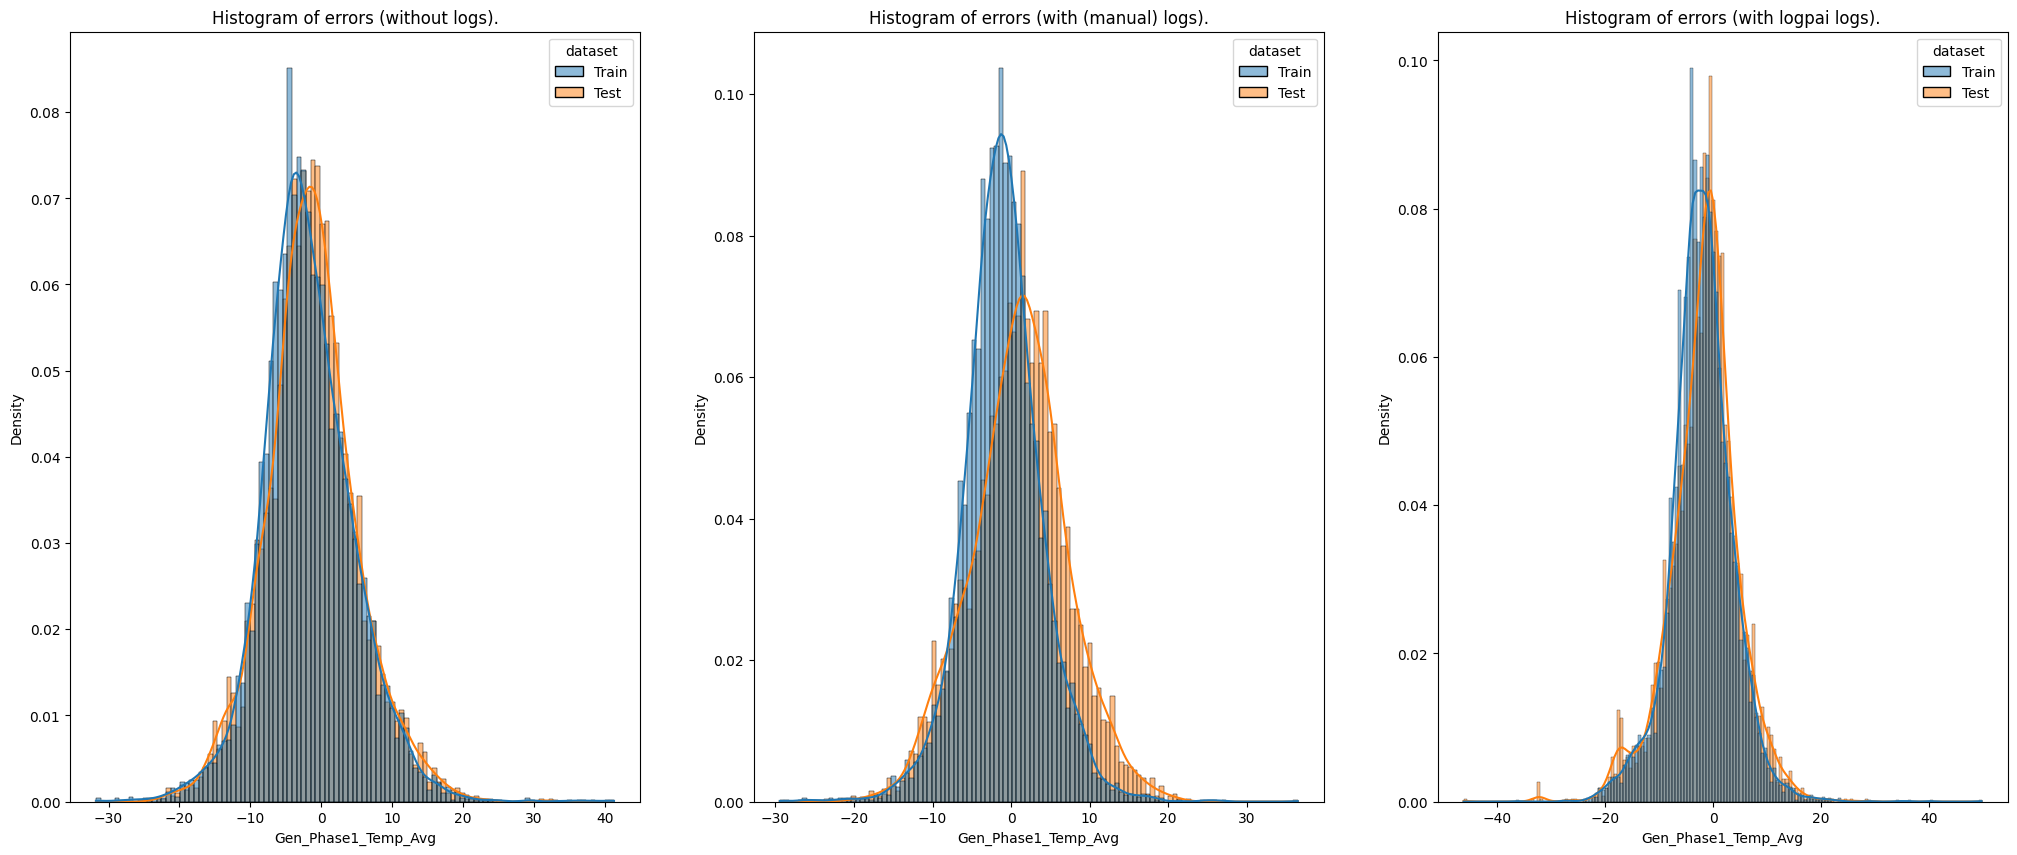

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(25,10))
errors_train_1_s['dataset'] = 'Train'
errors_test_1_s['dataset'] = 'Test'

errors_train_1_s_x['dataset'] = 'Train'
errors_test_1_s_x['dataset'] = 'Test'

errors_train_1_pai['dataset'] = 'Train'
errors_test_1_pai['dataset'] = 'Test'

sns.histplot(pd.concat([errors_train_1_s_x, errors_test_1_s_x], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[0])
sns.histplot(pd.concat([errors_train_1_s, errors_test_1_s], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[1])
sns.histplot(pd.concat([errors_train_1_pai, errors_test_1_pai], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[2])

axes[0].set_title('Histogram of errors (without logs).');
axes[1].set_title('Histogram of errors (with (manual) logs).');
axes[2].set_title('Histogram of errors (with logpai logs).');

Anomaly detection

In [16]:
anomaly_threshold_x_06_train = errors_train_1_s_x[target_feature].quantile(0.99)
anomaly_threshold_pai_06_train = errors_train_1_pai[target_feature].quantile(0.99)
anomaly_threshold_logs_06_train = errors_train_1_s[target_feature].quantile(0.99)

In [17]:
anomaly_threshold_logs_06_train

11.900214653015137

In [18]:
Y_train_1_s_x['Anomaly'] = errors_train_1_s_x[target_feature] > anomaly_threshold_x_06_train
Y_train_1_pai['Anomaly'] = errors_train_1_pai[target_feature] > anomaly_threshold_pai_06_train
Y_train_1_s['Anomaly'] = errors_train_1_s[target_feature] > anomaly_threshold_logs_06_train

In [19]:
n = 'quantile'
q = 0.99

n_x_1_train, Y_train_1_s_x = append_alarm_info(Y_train_1_s_x, n=n, q=q)
anomalies_x_1_train = Y_train_1_s_x[Y_train_1_s_x['Anomaly']]

n_pai_1_train, Y_train_1_pai = append_alarm_info(Y_train_1_pai, n=n, q=q)
anomalies_pai_1_train = Y_train_1_pai[Y_train_1_pai['Anomaly']]

n_logs_1_train, Y_train_1_s = append_alarm_info(Y_train_1_s, n=n, q=q)
anomalies_logs_1_train = Y_train_1_s[Y_train_1_s['Anomaly']]

/Users/backupuser/MA/Notebooks/../library/malib.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_Anomaly'].iloc[i] = df.iloc[i-1]['n_Anomaly'] + 1 if row['Anomaly'] else df.iloc[i-1]['n_Anomaly']
/Users/backupuser/MA/Notebooks/../library/malib.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_Anomaly'].iloc[i] = df.iloc[i-1]['n_Anomaly'] + 1 if row['Anomaly'] else df.iloc[i-1]['n_Anomaly']
/Users/backupuser/MA/Notebooks/../library/malib.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

In [20]:
anomaly_threshold_x_06_test = errors_train_1_s_x[target_feature].max()
anomaly_threshold_pai_06_test = errors_train_1_pai[target_feature].max()
anomaly_threshold_logs_06_test = errors_train_1_s[target_feature].max()

In [21]:
Y_test_1_s_x['Anomaly'] = errors_test_1_s_x[target_feature] > anomaly_threshold_x_06_train
Y_test_1_pai['Anomaly'] = errors_test_1_pai[target_feature] > anomaly_threshold_pai_06_train
Y_test_1_s['Anomaly'] = errors_test_1_s[target_feature] > anomaly_threshold_logs_06_train

In [22]:
n_x_1_test, Y_test_1_s_x = append_alarm_info(Y_test_1_s_x, n=n_x_1_train)
anomalies_x_1 = Y_test_1_s_x[Y_test_1_s_x['Anomaly']]

n_pai_1_test, Y_test_1_pai = append_alarm_info(Y_test_1_pai, n=n_pai_1_train)
anomalies_pai_1 = Y_test_1_pai[Y_test_1_pai['Anomaly']]

n_logs_1_test, Y_test_1_s = append_alarm_info(Y_test_1_s, n=n_logs_1_train)
anomalies_logs_1 = Y_test_1_s[Y_test_1_s['Anomaly']]

/Users/backupuser/MA/Notebooks/../library/malib.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_Anomaly'].iloc[i] = df.iloc[i-1]['n_Anomaly'] + 1 if row['Anomaly'] else df.iloc[i-1]['n_Anomaly']
/Users/backupuser/MA/Notebooks/../library/malib.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_Anomaly'].iloc[i] = df.iloc[i-1]['n_Anomaly'] + 1 if row['Anomaly'] else df.iloc[i-1]['n_Anomaly']
/Users/backupuser/MA/Notebooks/../library/malib.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

In [23]:
log_data_T06[log_data_T06['Remark'].str.contains('High temperature Gen2'.split('_')[0], na=False, case=False)]

TimeReset UnitTitle  \
TimeDetected                                          
2016-09-04 08:08:32+00:00  04.09.16 08:19       T06   
2016-09-04 08:23:49+00:00  04.09.16 08:35       T06   
2016-09-04 12:20:21+00:00  04.09.16 12:31       T06   
2016-09-30 22:08:48+00:00  30.09.16 23:46       T06   
2016-09-30 23:52:43+00:00  01.10.16 00:03       T06   
2016-10-01 00:07:41+00:00  01.10.16 00:19       T06   
2016-10-01 00:23:00+00:00  01.10.16 00:34       T06   
2016-10-01 00:38:25+00:00  01.10.16 00:50       T06   
2016-10-01 03:23:25+00:00  01.10.16 03:35       T06   
2016-10-01 03:40:01+00:00  01.10.16 03:50       T06   
2016-10-01 03:52:06+00:00  01.10.16 04:02       T06   
2016-10-01 04:05:47+00:00  01.10.16 05:03       T06   
2016-10-01 05:47:09+00:00  01.10.16 05:59       T06   
2016-10-01 09:18:14+00:00  01.10.16 09:28       T06   
2016-10-01 09:32:47+00:00  01.10.16 09:44       T06   
2016-10-01 10:30:21+00:00  01.10.16 10:40       T06   
2016-10-01 10:54:15+00:00  01.10.16 11:04       T06   
2016-10-01 11:35:28+00:00  01.10.16 11:46       T06   
2016-10-01 14:52:04+00:00  01.10.16 15:03       T06   
2016-10-01 16:55:00+00:00  01.10.16 17:09       T06   
2016-10-01 17:11:31+00:00  01.10.16 17:30       T06   
2016-10-01 17:48:34+00:00  01.10.16 17:59       T06   
2016-10-01 18:01:13+00:00  01.10.16 18:11       T06   
2016-10-01 18:16:04+00:00  01.10.16 18:56       T06   
2016-10-01 18:58:39+00:00  01.10.16 19:14       T06   
2016-10-01 20:42:01+00:00  01.10.16 22:57       T06   
2016-10-01 21:17:43+00:00  01.10.16 22:57       T06   
2016-10-02 05:42:38+00:00  02.10.16 05:53       T06   
2016-10-02 05:54:07+00:00  02.10.16 06:17       T06   
2016-10-02 12:34:07+00:00  02.10.16 13:11       T06   
2016-10-02 15:26:26+00:00  02.10.16 15:36       T06   
2016-10-02 17:30:13+00:00             NaN       T06   

                                                 Remark UnitTitleDestination  
TimeDetected                                                                  
2016-09-04 08:08:32+00:00  High temperature Gen2: 204°C                  NaN  
2016-09-04 08:23:49+00:00  High temperature Gen2: 158°C                  NaN  
2016-09-04 12:20:21+00:00  High temperature Gen2: 155°C                  NaN  
2016-09-30 22:08:48+00:00  High temperature Gen2: 193°C                  NaN  
2016-09-30 23:52:43+00:00  High temperature Gen2: 169°C                  NaN  
2016-10-01 00:07:41+00:00  High temperature Gen2: 185°C                  NaN  
2016-10-01 00:23:00+00:00  High temperature Gen2: 202°C                  NaN  
2016-10-01 00:38:25+00:00  High temperature Gen2: 204°C                  NaN  
2016-10-01 03:23:25+00:00  High temperature Gen2: 204°C                  NaN  
2016-10-01 03:40:01+00:00  High temperature Gen2: 169°C                  NaN  
2016-10-01 03:52:06+00:00  High temperature Gen2: 204°C                  NaN  
2016-10-01 04:05:47+00:00  High temperature Gen2: 204°C                  NaN  
2016-10-01 05:47:09+00:00  High temperature Gen2: 180°C                  NaN  
2016-10-01 09:18:14+00:00  High temperature Gen2: 162°C                  NaN  
2016-10-01 09:32:47+00:00  High temperature Gen2: 204°C                  NaN  
2016-10-01 10:30:21+00:00  High temperature Gen2: 158°C                  NaN  
2016-10-01 10:54:15+00:00  High temperature Gen2: 204°C                  NaN  
2016-10-01 11:35:28+00:00  High temperature Gen2: 162°C                  NaN  
2016-10-01 14:52:04+00:00  High temperature Gen2: 191°C                  NaN  
2016-10-01 16:55:00+00:00  High temperature Gen2: 204°C                  NaN  
2016-10-01 17:11:31+00:00  High temperature Gen2: 182°C                  NaN  
2016-10-01 17:48:34+00:00  High temperature Gen2: 204°C                  NaN  
2016-10-01 18:01:13+00:00  High temperature Gen2: 204°C                  NaN  
2016-10-01 18:16:04+00:00  High temperature Gen2: 171°C                  NaN  
2016-10-01 18:58:39+00:00  High temperature Gen2: 201°C                  NaN  
2016-10-01 20:42:01+00:00  H

In [24]:
Y_test_1_s_x = append_relevant_log_warnings(Y_test_1_s_x, log_data_T06, 'Remark', 'High temperature Gen2', filter_by='Alarm', max_distance='24H')
Y_test_1_pai = append_relevant_log_warnings(Y_test_1_pai, log_data_T06, 'Remark', 'High temperature Gen2', filter_by='Alarm', max_distance='24H')
Y_test_1_s = append_relevant_log_warnings(Y_test_1_s, log_data_T06, 'Remark', 'High temperature Gen2', filter_by='Alarm', max_distance='24H')

Empty DataFrame
Columns: [Gen_Phase1_Temp_Avg, Anomaly, Diff_in_days, n_Anomaly, Alarm, logs_found]
Index: []

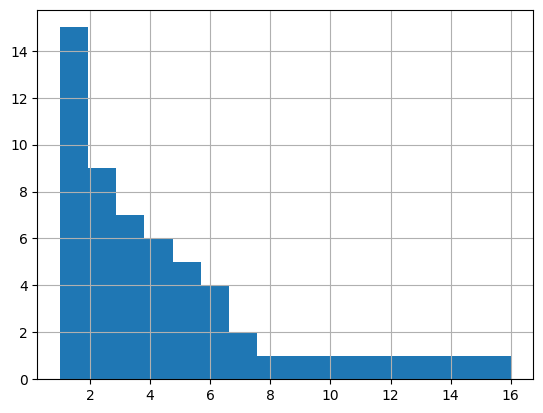

In [25]:
anomalies_x_1['n_Anomaly'].hist(bins=anomalies_x_1['n_Anomaly'].max() - anomalies_x_1['n_Anomaly'].min() + 1)
Y_test_1_s_x[Y_test_1_s_x.Alarm]

Empty DataFrame
Columns: [Gen_Phase1_Temp_Avg, Anomaly, Diff_in_days, n_Anomaly, Alarm, logs_found]
Index: []

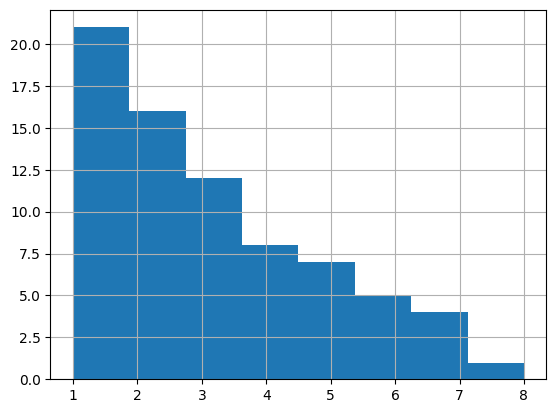

In [26]:
anomalies_pai_1['n_Anomaly'].hist(bins=anomalies_pai_1['n_Anomaly'].max() - anomalies_pai_1['n_Anomaly'].min() + 1)
Y_test_1_pai[Y_test_1_pai.Alarm]

In [27]:
Y_test_1_s.logs_found.unique()

array([None, 'No logs found',
       'High temperature Gen2: 157°C @ 2016-10-01 20:42:01+00:00\n High temperature Gen2: 159°C @ 2016-10-01 21:17:43+00:00\n High temperature Gen2: 204°C @ 2016-10-02 05:42:38+00:00\n High temperature Gen2: 157°C @ 2016-10-02 05:54:07+00:00\n High temperature Gen2: 204°C @ 2016-10-02 12:34:07+00:00\n High temperature Gen2: 191°C @ 2016-10-02 15:26:26+00:00\n High temperature Gen2: 204°C @ 2016-10-02 17:30:13+00:00\n ',
       'High temperature Gen2: 204°C @ 2016-10-02 05:42:38+00:00\n High temperature Gen2: 157°C @ 2016-10-02 05:54:07+00:00\n High temperature Gen2: 204°C @ 2016-10-02 12:34:07+00:00\n High temperature Gen2: 191°C @ 2016-10-02 15:26:26+00:00\n High temperature Gen2: 204°C @ 2016-10-02 17:30:13+00:00\n '],
      dtype=object)

Gen_Phase1_Temp_Avg  Anomaly  Diff_in_days  \
Timestamp                                                               
2016-09-25 09:10:00+00:00                   57     True           0.0   
2016-09-25 09:20:00+00:00                   56     True           0.0   
2016-09-25 09:30:00+00:00                   56     True           0.0   
2016-09-25 09:40:00+00:00                   56     True           0.0   
2016-09-25 09:50:00+00:00                   55     True           0.0   
2016-09-25 10:00:00+00:00                   55     True           0.0   
2016-09-25 10:10:00+00:00                   54     True           0.0   
2016-09-25 10:20:00+00:00                   54     True           0.0   
2016-09-25 10:30:00+00:00                   54     True           0.0   
2016-09-25 10:40:00+00:00                   53     True           0.0   
2016-09-25 10:50:00+00:00                   53     True           0.0   
2016-09-25 11:00:00+00:00                   52     True           0.0   
2016-09-25 11:10:00+00:00                   52     True           0.0   
2016-09-25 11:20:00+00:00                   52     True           0.0   
2016-09-25 11:30:00+00:00                   51     True           0.0   
2016-09-25 11:40:00+00:00                   51     True           0.0   
2016-09-25 11:50:00+00:00                   51     True           0.0   
2016-09-25 12:00:00+00:00                   50     True           0.0   
2016-09-25 12:10:00+00:00                   50     True           0.0   
2016-09-25 12:20:00+00:00                   50     True           0.0   
2016-09-25 12:30:00+00:00                   49     True           0.0   
2016-09-25 12:40:00+00:00                   49     True           0.0   
2016-09-25 12:50:00+00:00                   49     True           0.0   
2016-09-25 13:00:00+00:00                   48     True           0.0   
2016-09-25 13:10:00+00:00                   48     True           0.0   
2016-09-25 13:20:00+00:00                   48     True           0.0   
2016-09-25 13:30:00+00:00                   48     True           0.0   
2016-09-25 13:40:00+00:00                   48     True           0.0   
2016-09-25 14:00:00+00:00                   47     True           0.0   
2016-09-25 14:10:00+00:00                   47     True           0.0   
2016-09-25 14:20:00+00:00                   47     True           0.0   
2016-09-25 18:10:00+00:00                   54     True           0.0   
2016-09-25 18:20:00+00:00                   52     True           0.0   
2016-09-25 19:40:00+00:00                   53     True           0.0   
2016-10-02 20:00:00+00:00                   62     True           0.0   
2016-10-02 20:20:00+00:00                   62     True           0.0   
2016-10-02 22:00:00+00:00                   61     True           0.0   
2016-10-02 22:10:00+00:00                   61     True           0.0   
2016-10-02 22:20:00+00:00                   61     True           0.0   
2016-10-02 22:50:00+00:00                   56     True           0.0   
2016-10-02 23:00:00+00:00                   54     True           0.0   
2016-10-02 23:10:00+00:00                   51     True           0.0   
2016-10-02 23:20:00+00:00                   49     True           0.0   
2016-10-02 23:30:00+00:00                   47     True           0.0   
2016-10-05 19:40:00+00:00                   94     True           0.0   
2016-10-05 19:50:00+00:00                   92     True           0.0   
2016-10-05 20:00:00+00:00                   92     True           0.0   
2016-10-05 20:40:00+00:00                   96     True           0.0   
2016-10-05 21:50:00+00:00                   91     True           0.0   
2016-10-05 22:00:00+00:00                   89     True           0.0   
2016-10-05 22:10:00+00:00                   86     True           0.0   
2016-10-16 10:10:00+00:00                   53     True           0.0   
2016-10-16 10:20:00+00:00                   51     True           0.0   
2016-10-16 1

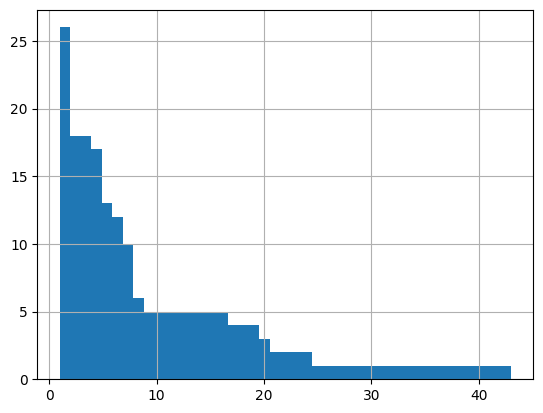

In [28]:
anomalies_logs_1['n_Anomaly'].hist(bins=anomalies_logs_1['n_Anomaly'].max() - anomalies_logs_1['n_Anomaly'].min() + 1)
Y_test_1_s[Y_test_1_s.Alarm]

In [29]:
plt.figure(figsize=(25,15))
sns.lineplot(x=Y_train_1.index, y=Y_train_1[y_column])
sns.lineplot(x=predictions_train_1.index, y=predictions_train_1[y_column], color='orange')

for ix, row in lgs_int[Y_train_1.index[0] : Y_train_1.index[-1]].iterrows():
  if 'Gen. int. vent. 0' in row.Remark:
    plt.axvline(x=ix, linestyle='--', color='red')
  elif 'Gen. int. vent. 1' in row.Remark:
    plt.axvline(x=ix, linestyle='--', color='green')
  elif 'Gen. int. vent. 2' in row.Remark:
    plt.axvline(x=ix, linestyle='--', color='black')

plt.grid(True)
plt.legend(['Gen Bear Temp (True)', 'Gen Bear Temp (Predicted)', 'Gen int Vent 0', 'Gen int Vent 1', 'Gen int Vent 2'])

NameError: name 'Y_train_1' is not defined

<Figure size 2500x1500 with 0 Axes>

In [ ]:
relevant_logs = log_data_T06[log_data_T06.Remark.str.contains('High temperature Gen2', na=False, case=False)]
Y_test_1['logs_found'] = None
for index, row in Y_test_1[Y_test_1.Anomaly].iterrows():
  filtered_logs = relevant_logs[(index - pd.Timedelta('24H')) : index]
  if not filtered_logs.empty:
    string = ''
    for i, r in filtered_logs.iterrows():
      string = string + r.Remark + ' @ ' + str(i) + '\n '
    Y_test_1.loc[index, 'logs_found'] = string

  else:
    Y_test_1.loc[index, 'logs_found'] = 'No logs found'

In [ ]:
Y_test_1.loc['2016-10-27 16:30:00+00', 'logs_found'] = 'Generator replaced'

In [ ]:
# gt = pd.concat([Y_test_1['2016-02-26 18:00' : '2016-02-26 20:00'], Y_test_1['2016-08-22 10:00' : '2016-08-22 20:00'], 
#                 Y_test_1['2016-09-01 13:00' : '2016-09-01 15:00'], Y_test_1['2016-10-06 02:00' : '2016-10-06 04:00'], 
#                 Y_test_1['2016-10-17 08:00' : '2016-10-17 10:00']])
# pr = pd.concat([predictions_test_1['2016-02-26 18:00' : '2016-02-26 20:00'], predictions_test_1['2016-08-22 10:00' : '2016-08-22 20:00'], 
#                 predictions_test_1['2016-09-01 13:00' : '2016-09-01 15:00'], predictions_test_1['2016-10-06 02:00' : '2016-10-06 04:00'], 
#                 predictions_test_1['2016-10-17 08:00' : '2016-10-17 10:00']])

gt = Y_test_1['2016-09-24' : '2016-10-28']
pr = predictions_test_1['2016-09-24' : '2016-10-28']

gt.reset_index(inplace=True)
pr.reset_index(inplace=True)

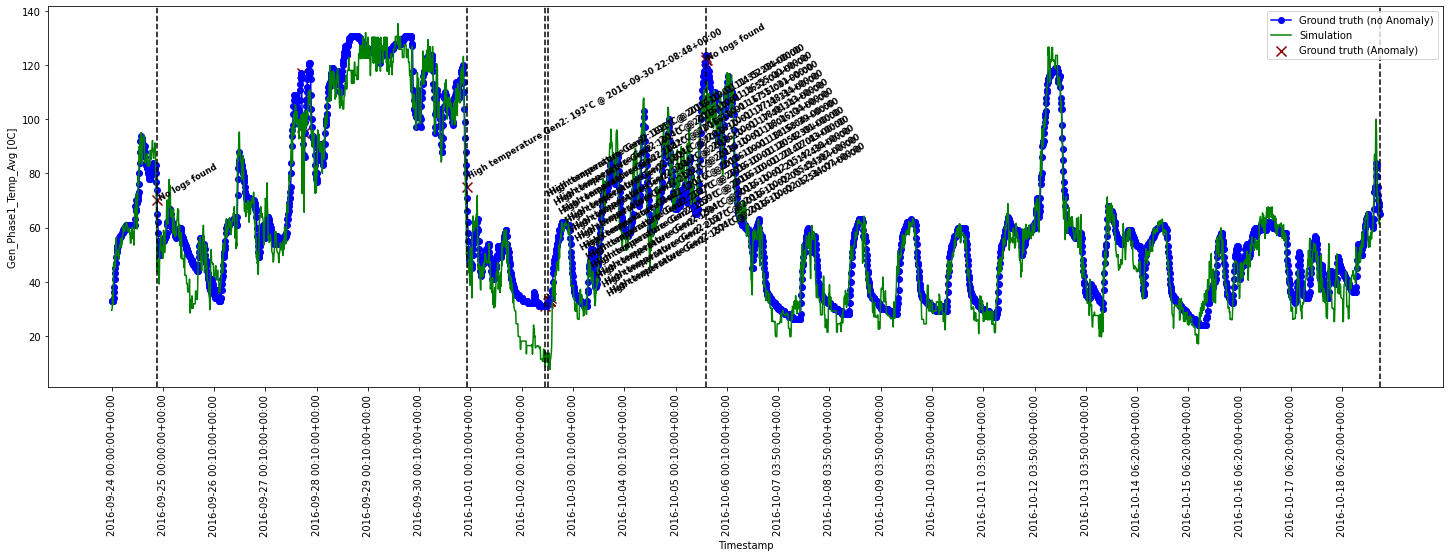

In [ ]:
#plt.figure(figsize=(25,15))
#sns.scatterplot(x='Timestamp', y='Gen_Bear_Temp_Avg', hue='Anomaly', data=Y_test_1['2016-08-22' : '2016-08-22'].reset_index())
plot_predicted_vs_true(pr, gt, y_column, hue='Anomaly')

last_logs_found = ''
for line in range(0, gt.shape[0], 1):
  if gt.Anomaly[line] and gt.logs_found[line] != last_logs_found:
    plt.text(gt.index[line], gt.Gen_Phase1_Temp_Avg[line], gt.logs_found[line], size='small', color='black', weight='semibold', rotation=30)
    plt.axvline(x=gt.index[line], linestyle='--', color='black')
    last_logs_found = gt.logs_found[line]

  elif gt.logs_found[line] == 'Generator replaced':
      plt.text(gt.index[line], gt.Gen_Phase1_Temp_Avg[line], '!GENERATOR REPLACED!', size='medium', color='black', weight='bold', rotation=30)
      plt.axvline(x=gt.index[line], linestyle='--', color='darkred')
plt.xticks(range(0, gt.shape[0], 144), labels = gt['Timestamp'][:-1:144], rotation=90);
plt.grid(False);

In [ ]:
Y_train_1[Y_train_1['Anomaly']]

Empty DataFrame
Columns: [Gen_Bear_Temp_Avg, Anomaly]
Index: []

Text(0, 0.5, 'Gen Bearing Temp Error [0C]')

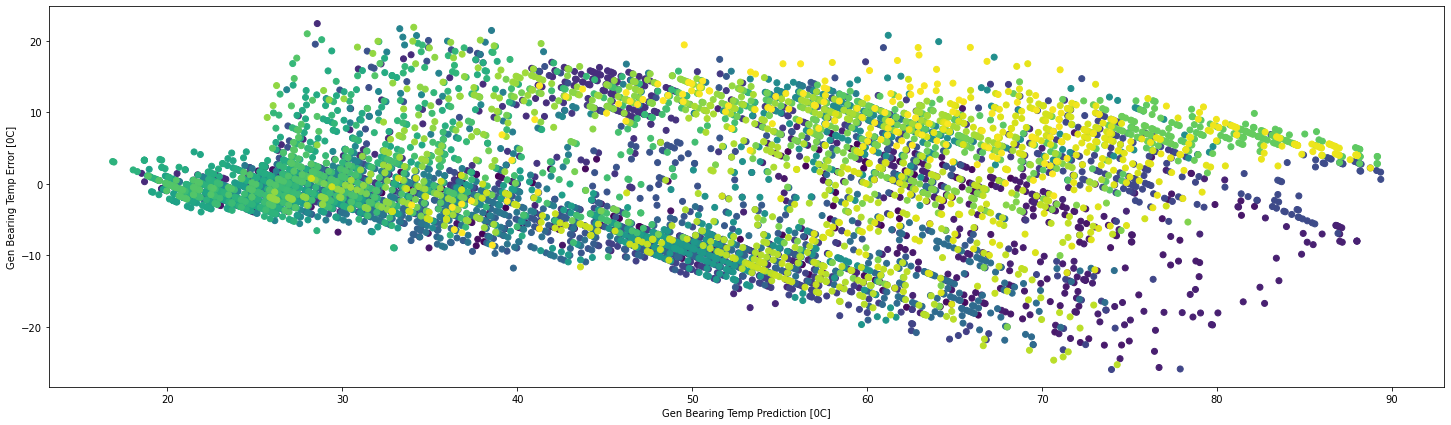

In [ ]:
#Error vs target
fig = plt.figure(figsize=(25,7))
plt.scatter(predictions_train_1[y_column], errors_train_1[y_column], c=[i for i in range(errors_train_1.shape[0])])
plt.xlabel('Gen Bearing Temp Prediction [0C]')
plt.ylabel('Gen Bearing Temp Error [0C]')

In [ ]:
X_train_neg_err = X_train_1[(errors_train_1['Gen_Bear_Temp_Avg'] < -7) & (errors_train_1['Gen_Bear_Temp_Avg'] > -10)]
Y_train_neg_err = Y_train_1[(errors_train_1['Gen_Bear_Temp_Avg'] < -7) & (errors_train_1['Gen_Bear_Temp_Avg'] > -10)]

pred_train_neg_err = predictions_train_1[(errors_train_1['Gen_Bear_Temp_Avg'] < -7) & (errors_train_1['Gen_Bear_Temp_Avg'] > -10)]

In [ ]:
Y_train_neg_err = pd.merge_asof(Y_train_neg_err, log_data_T06['Remark'], left_index = True, right_index = True, tolerance = pd.Timedelta('10m'))

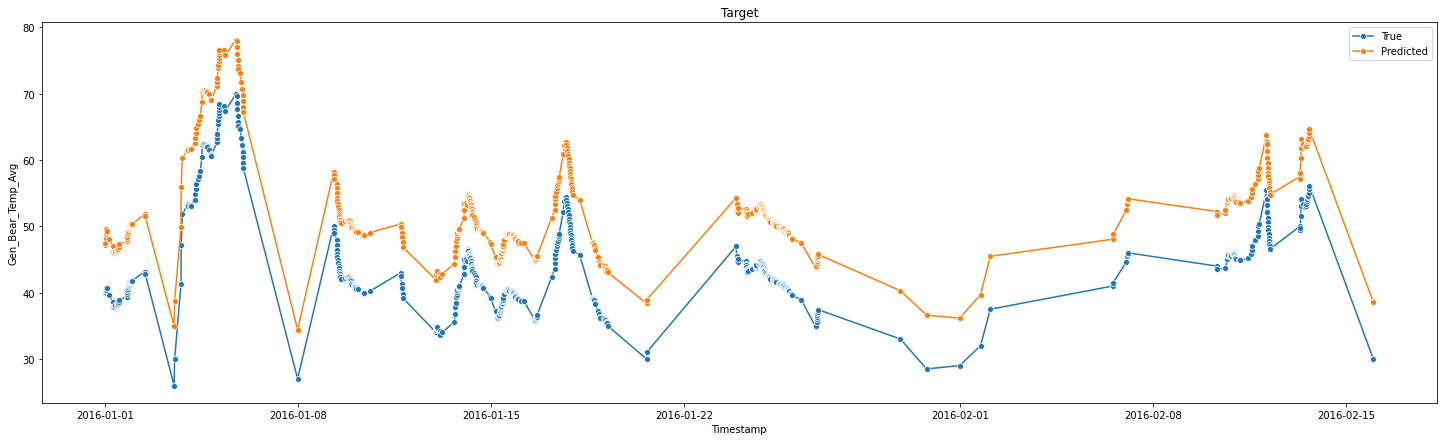

In [ ]:
plt.figure(figsize=(25,7))
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=Y_train_neg_err.rolling('1D').mean(), marker='o')
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=pred_train_neg_err.rolling('1D').mean(), marker='o')
ax.set_title('Target');
ax.legend(['True', 'Predicted'])

In [ ]:
log_data_T06.Remark[log_data_T06.Remark.str.contains('Gen. int. vent. 0, temp: 50.5°C', na=False)]

Series([], Name: Remark, dtype: object)

In [ ]:
T06_data_logs['Int_Vent_0_Temp'].unique()

array([  nan,  34. ,  39. ,  67. ,  50. ,  47. ,  50.5,  49. ,  55. ,
        48. ,  45. ,  58. ,  21. ,  63. ,  73. ,  40. , 116. ,  91. ,
        61. ,  64. ,  89. ,  68. ,  62. ,  42. ,  70. ,  41. ,  95. ,
       107. ,  37. ,  54. ,  35. ])

In [ ]:
T06_data_logs['Int_Vent_1_Temp'].unique()

array([  nan,  34. ,  39. ,  67. ,  50. ,  47. ,  50.5,  49. ,  55. ,
        48. ,  45. ,  58. ,  21. ,  63. ,  73. ,  40. , 116. ,  91. ,
        61. ,  64. ,  89. ,  68. ,  62. ,  42. ,  70. ,  41. ,  95. ,
       107. ,  37. ,  54. ,  35. ])

In [ ]:
(log_data_T06[log_data_T06.Remark.str.contains('Gen. ext. vent. 0').fillna(False)].Remark).unique()

In [ ]:
X_train_pos_err = X_train_1[(errors_train_1['Gen_Bear_Temp_Avg'] > 7) & (errors_train_1['Gen_Bear_Temp_Avg'] < 10)]
Y_train_pos_err = Y_train_1[(errors_train_1['Gen_Bear_Temp_Avg'] > 7) & (errors_train_1['Gen_Bear_Temp_Avg'] < 10)]

pred_train_pos_err = predictions_train_1[(errors_train_1['Gen_Bear_Temp_Avg'] > 7) & (errors_train_1['Gen_Bear_Temp_Avg'] < 10)]


In [ ]:
Y_train_pos_err = pd.merge_asof(Y_train_pos_err, log_data_T06['Remark'], left_index = True, right_index = True, tolerance = pd.Timedelta('10m'))

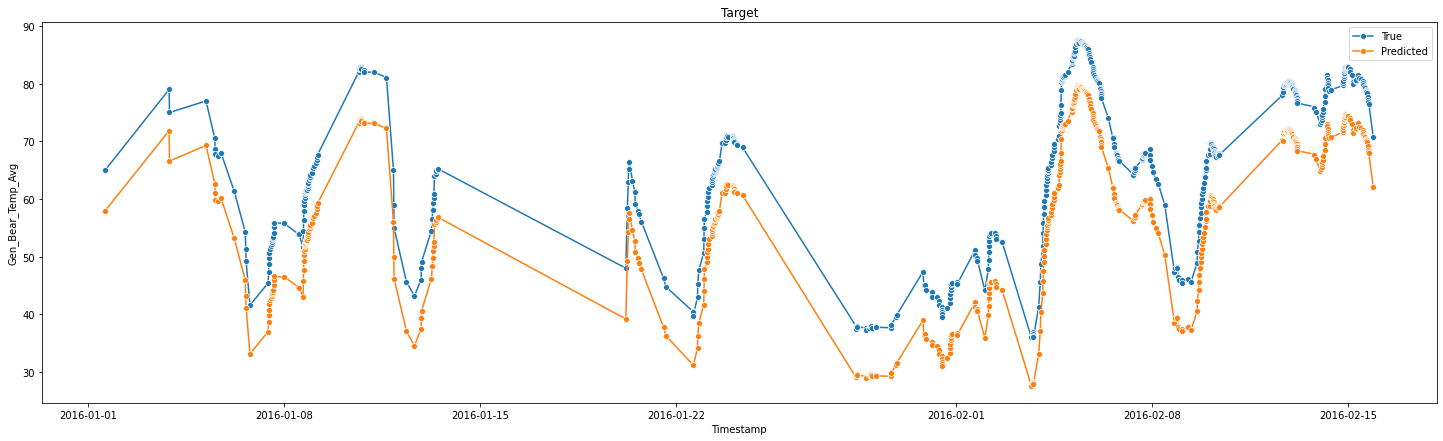

In [ ]:
plt.figure(figsize=(25,7))
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=Y_train_pos_err.rolling('1D').mean(), marker='o')
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=pred_train_pos_err.rolling('1D').mean(), marker='o')
ax.set_title('Target');
ax.legend(['True', 'Predicted'])

In [ ]:
X_train_zero_err = X_train_1[(errors_train_1['Gen_Bear_Temp_Avg'] > -1) & (errors_train_1['Gen_Bear_Temp_Avg'] < 1)]
Y_train_zero_err = Y_train_1[(errors_train_1['Gen_Bear_Temp_Avg'] > -1) & (errors_train_1['Gen_Bear_Temp_Avg'] < 1)]

pred_train_zero_err = predictions_train_1[(errors_train_1['Gen_Bear_Temp_Avg'] > -1) & (errors_train_1['Gen_Bear_Temp_Avg'] < 1)]

In [ ]:
Y_train_zero_err = pd.merge_asof(Y_train_zero_err, log_data_T06['Remark'], left_index = True, right_index = True, tolerance = pd.Timedelta('10m'))

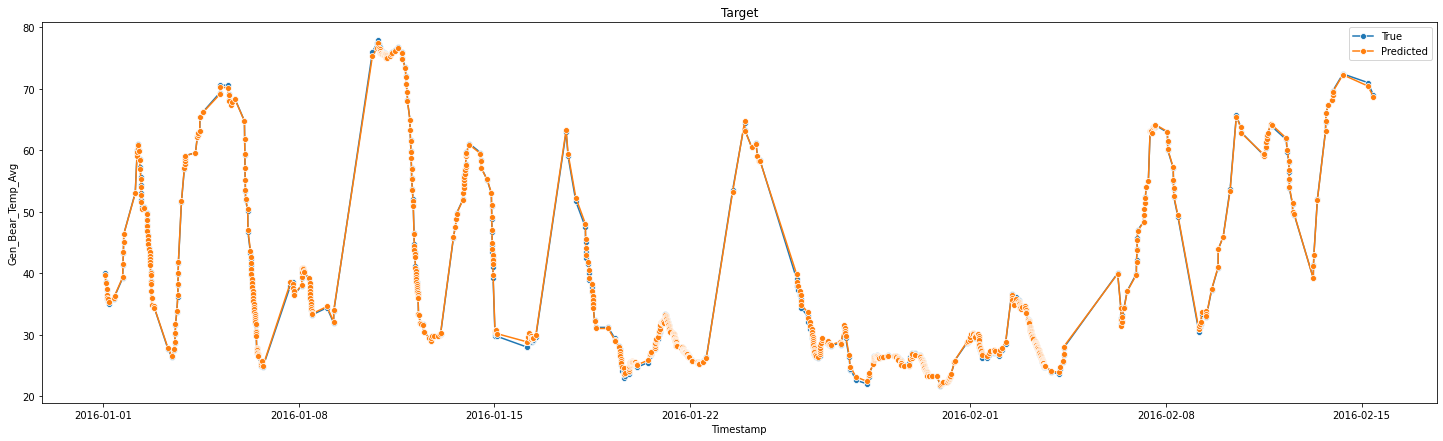

In [ ]:
plt.figure(figsize=(25,7))
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=Y_train_zero_err.rolling('1D').mean(), marker='o')
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=pred_train_zero_err.rolling('1D').mean(), marker='o')
ax.set_title('Target');
ax.legend(['True', 'Predicted'])

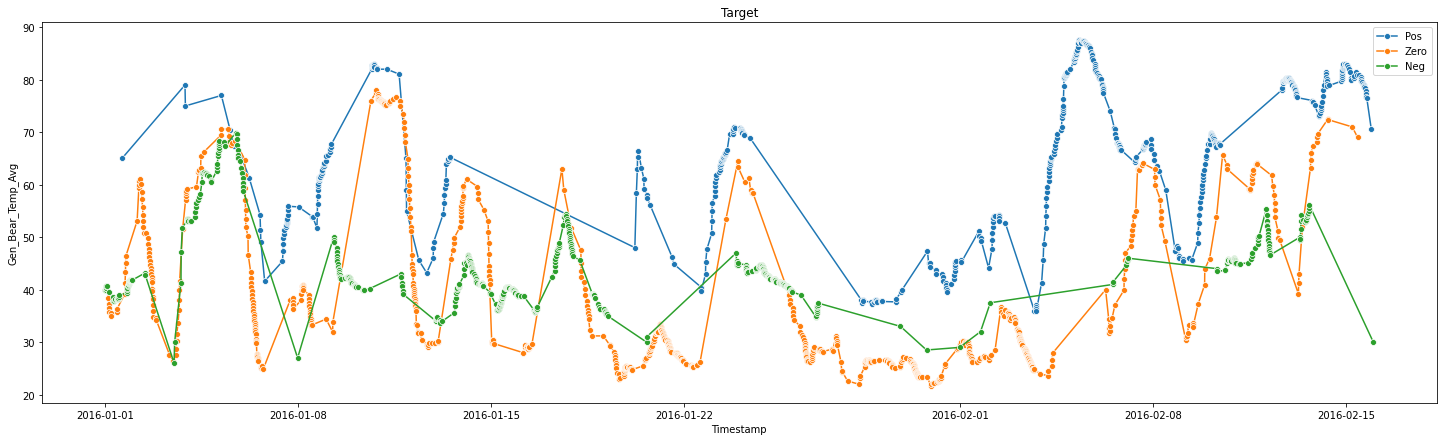

In [ ]:
plt.figure(figsize=(25,7))
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=Y_train_pos_err.rolling('1D').mean(), marker='o')
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=Y_train_zero_err.rolling('1D').mean(), marker='o')
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=Y_train_neg_err.rolling('1D').mean(), marker='o')
ax.set_title('Target');
ax.legend(['Pos', 'Zero', 'Neg'])

In [ ]:
Y_train_pos_err['err'] = 'pos'
Y_train_neg_err['err'] = 'neg'
Y_train_zero_err['err'] = 'zero'
Y_train_err = pd.concat([Y_train_pos_err, Y_train_neg_err, Y_train_zero_err], ignore_index=True)

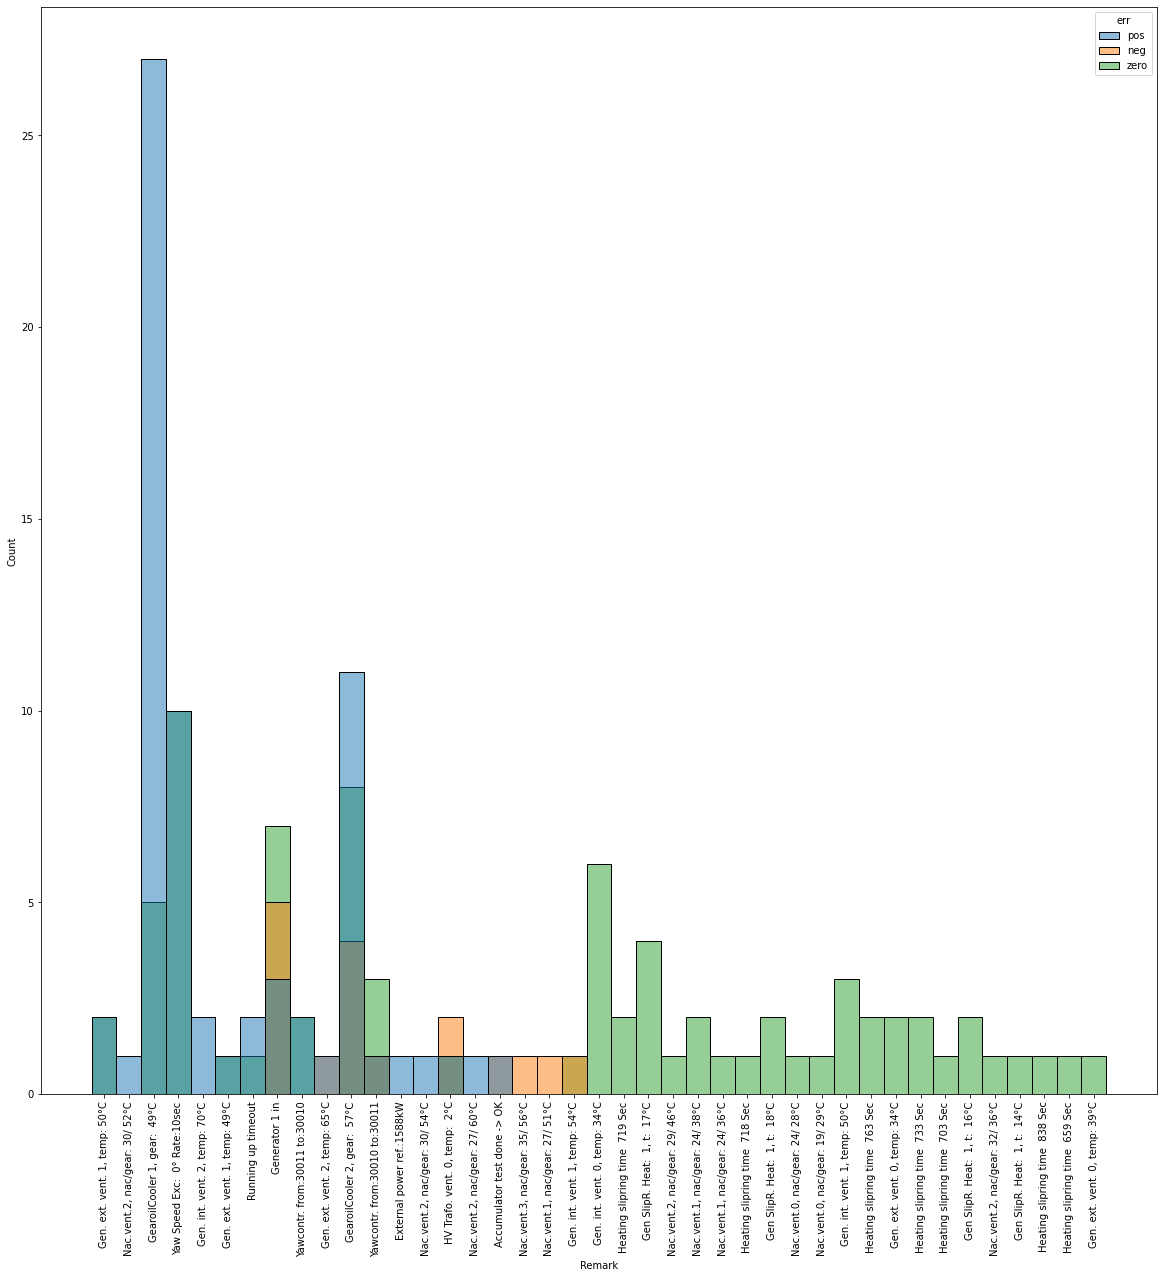

In [ ]:
plt.figure(figsize=(20,20))
sns.histplot(data=Y_train_err[Y_train_err['Remark'] != 'External power ref.:2000kW'], x='Remark', hue='err')
plt.xticks(rotation=90);

Text(0, 0.5, 'Gen Bearing Temp Error [0C]')

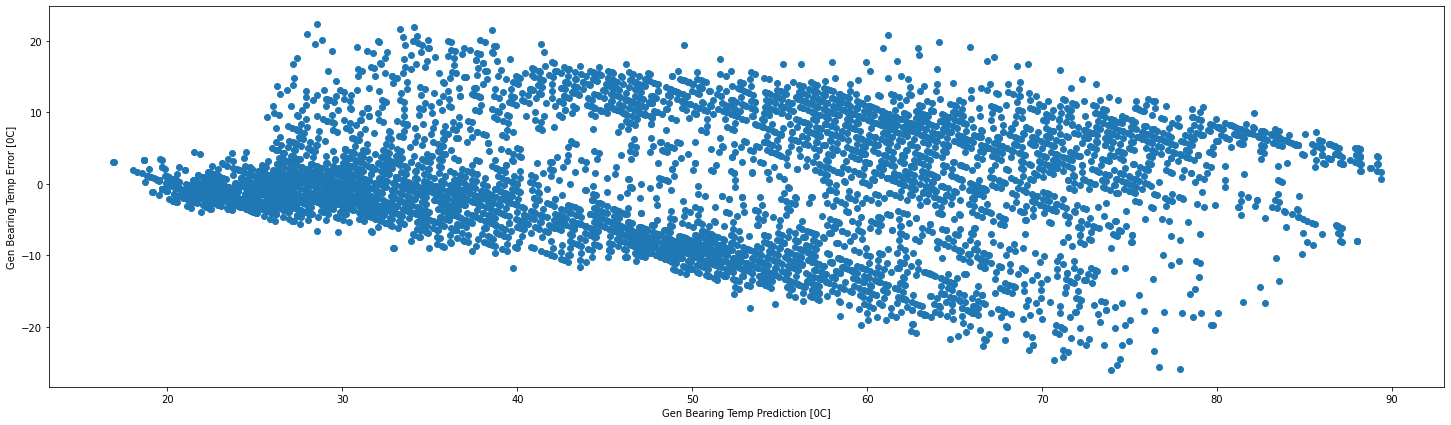

In [ ]:
#Error vs target
fig = plt.figure(figsize=(25,7))
plt.scatter(predictions_train_1[y_column], errors_train_1[y_column])
plt.xlabel('Gen Bearing Temp Prediction [0C]')
plt.ylabel('Gen Bearing Temp Error [0C]')

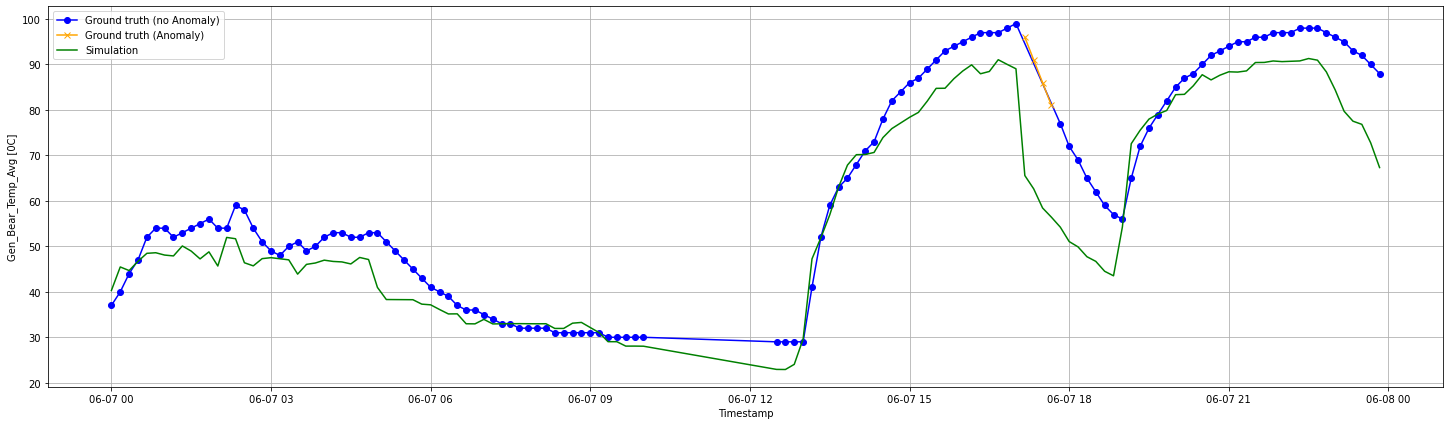

In [ ]:
#Failure 1: June 7, 2016 4:59 PM High temperature generator bearing
X_fail_1 = X_test_1.loc['2016-06-07':'2016-06-07']
Y_fail_1 = Y_test_1.loc['2016-06-07':'2016-06-07']
plot_predicted_vs_true(pd.DataFrame(model_1.predict(X_fail_1), columns=[y_column], index=X_fail_1.index),Y_fail_1, y_column, hue='Anomaly')
#plot_error(pd.DataFrame(model_1.predict(X_fail_1), columns=[y_column], index=X_fail_1.index),Y_fail_1, y_column)

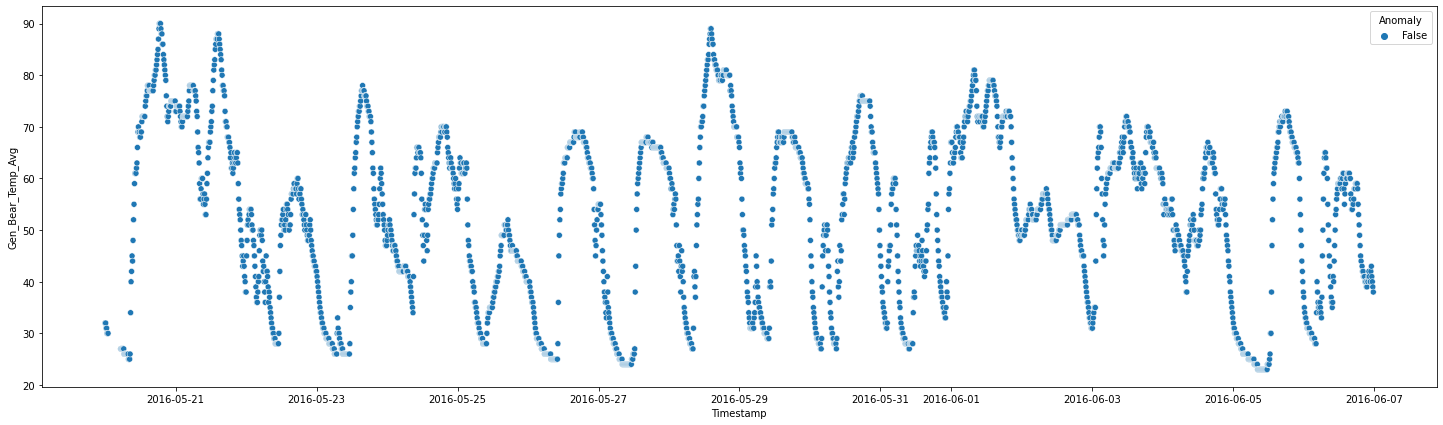

In [ ]:
#Before failure
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_1['2016-05-20':'2016-06-06'].reset_index())

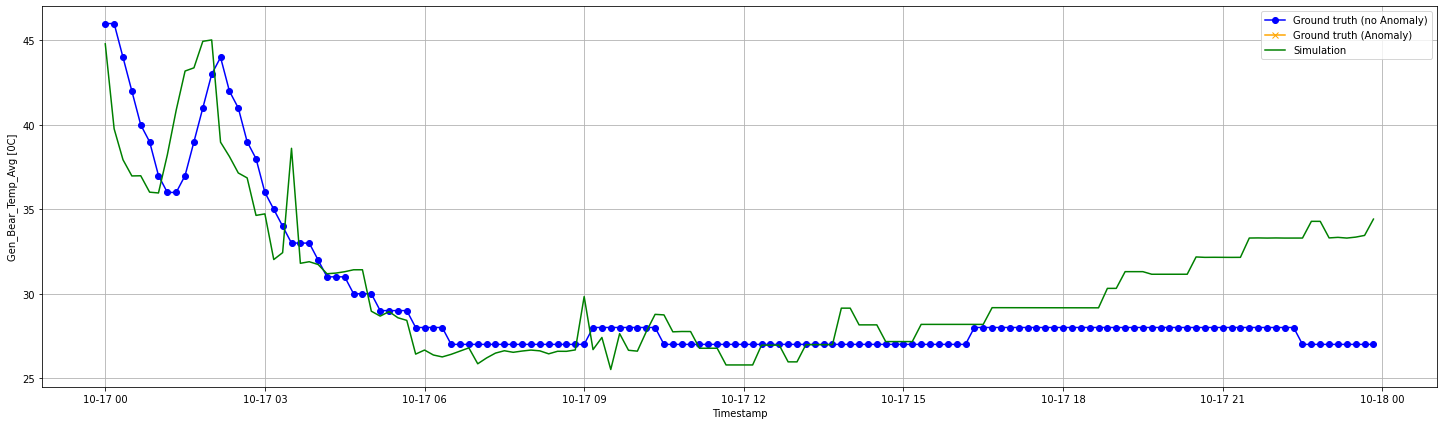

In [ ]:
#Failure 2: October 17, 2016 9:19 AM Generator bearings replaced
X_fail_2 = X_test_1.loc['2016-10-17':'2016-10-17']
Y_fail_2 = Y_test_1.loc['2016-10-17':'2016-10-17']
plot_predicted_vs_true(pd.DataFrame(model_1.predict(X_fail_2), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column, hue='Anomaly')
#plot_error(pd.DataFrame(model_1.predict(X_fail_2), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column)

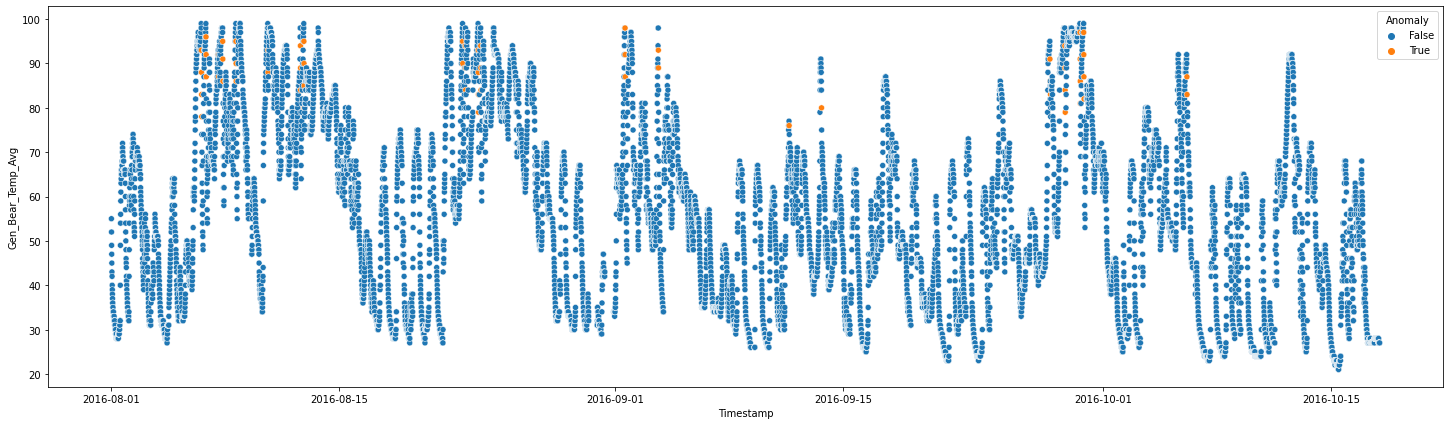

In [ ]:
#Before failure
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_1['2016-08-01':'2016-10-17'].reset_index())

**Compare error distributions of all turbines**

In [ ]:
combined_errors_train = errors_train_1
combined_errors_train['turbine_id'] = 'T06'

combined_errors_test = errors_test_1
combined_errors_test['turbine_id'] = 'T06'

combined_Y_test = pd.DataFrame()

In [ ]:
features = ['Nac_Temp_Avg', 'Amb_Temp_Avg', 'Gen_RPM_Avg', 'Grd_Prod_Pwr_Avg', 'Gen_Bear_Temp_Avg', 'Grd_Busbar_Temp_Avg', 
            ]

In [ ]:
for t_id in ['T01',]: #T01 is the only WTG no Generator Failures were reported for
  _, _, _, _, errors_train, _, Y_test, _, errors_test, _, = \
                        implement_pipeline_reg(all_data, train_date_start = '2016-01-01', train_date_end = '2016-02-15',
                                           test_date_start = '2016-02-16', test_date_end = '2016-10-18', y_column = y_column, turbine_id=t_id,
                         features=features);
  errors_train['turbine_id'] = t_id
  combined_errors_train = pd.concat([combined_errors_train, errors_train], ignore_index=True)

  errors_test['turbine_id'] = t_id
  combined_errors_test = pd.concat([combined_errors_test, errors_test], ignore_index=True)

  Y_test['turbine_id'] = t_id
  Y_test['Anomaly'] = errors_test[y_column] > anomaly_threshold
  #Y_test['Anomaly'] = errors_test[y_column] > 26
  combined_Y_test = pd.concat([combined_Y_test, Y_test.reset_index()], ignore_index=True)

Training model...
Evaluating model...
Score for training data:  0.8886028488444764
Score for test data:  0.8837617669922871


In [ ]:
combined_errors_test[combined_errors_test['turbine_id'] == 'T01']['Gen_Bear_Temp_Avg'].max()

23.27877700283637

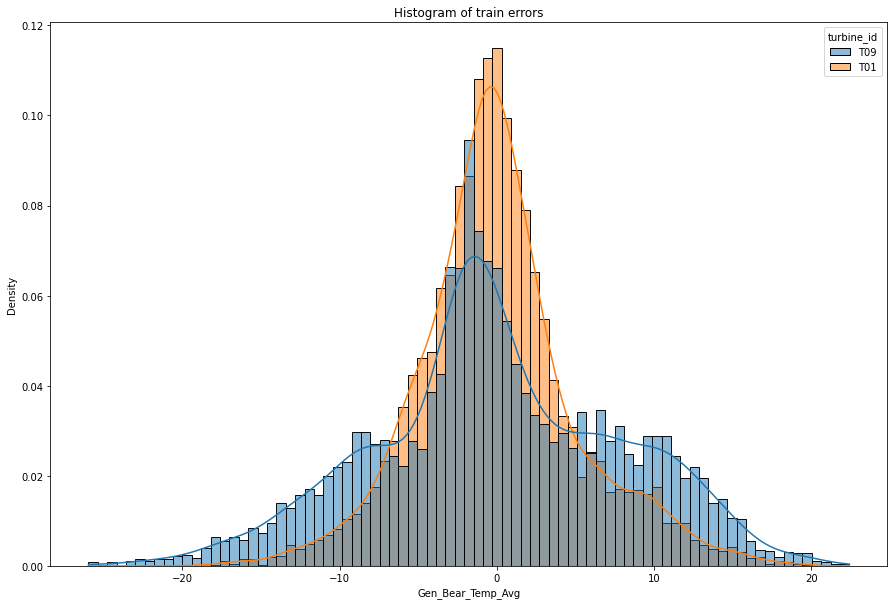

In [ ]:
fig = plt.figure(figsize=(15,10))
ax=sns.histplot(data=combined_errors_train, x=y_column, hue='turbine_id', kde=True, stat='density', common_norm=False)
ax.set_title('Histogram of train errors');

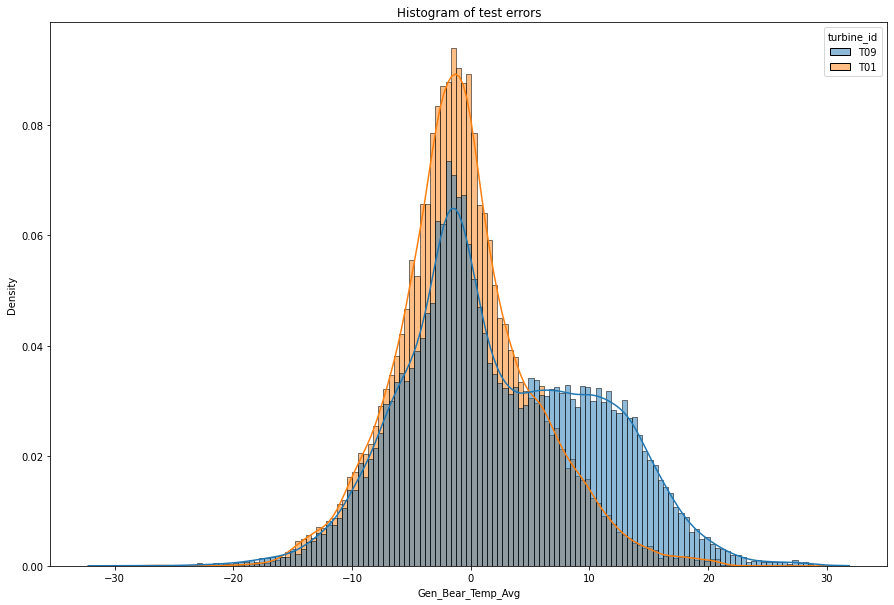

In [ ]:
fig = plt.figure(figsize=(15,10))
ax=sns.histplot(data=combined_errors_test, x=y_column, hue='turbine_id', kde=True, stat='density', common_norm=False)
ax.set_title('Histogram of test errors');

0


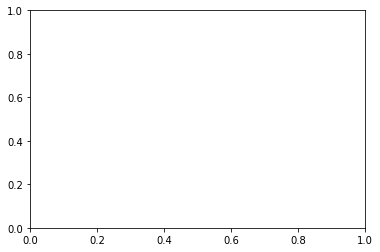

In [ ]:
#Anomalies?
print(combined_Y_test[combined_Y_test.Anomaly].shape[0])
sns.scatterplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=combined_Y_test[combined_Y_test.Anomaly], hue='turbine_id')

**Deep Learning**

**Batch 1:** Train Jan-May, Test Jun-Nov

In [ ]:
dataset_2, X_train_2, Y_train_2, predictions_train_2, errors_train_2, X_test_2, Y_test_2, predictions_test_2, errors_test_2, model_2, scaler_input, scaler_target = \
                        implement_pipeline_mlp(T06_data, train_date_start = '2016-01-01', train_date_end = '2016-05-15',
                                           test_date_start = '2016-05-16', test_date_end = '2016-11-30', y_column = y_column, turbine_id='T06',
                         features=features, epochs=300, normalize=True);

Training model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                608       
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dropout_8 (Dropout)         (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 

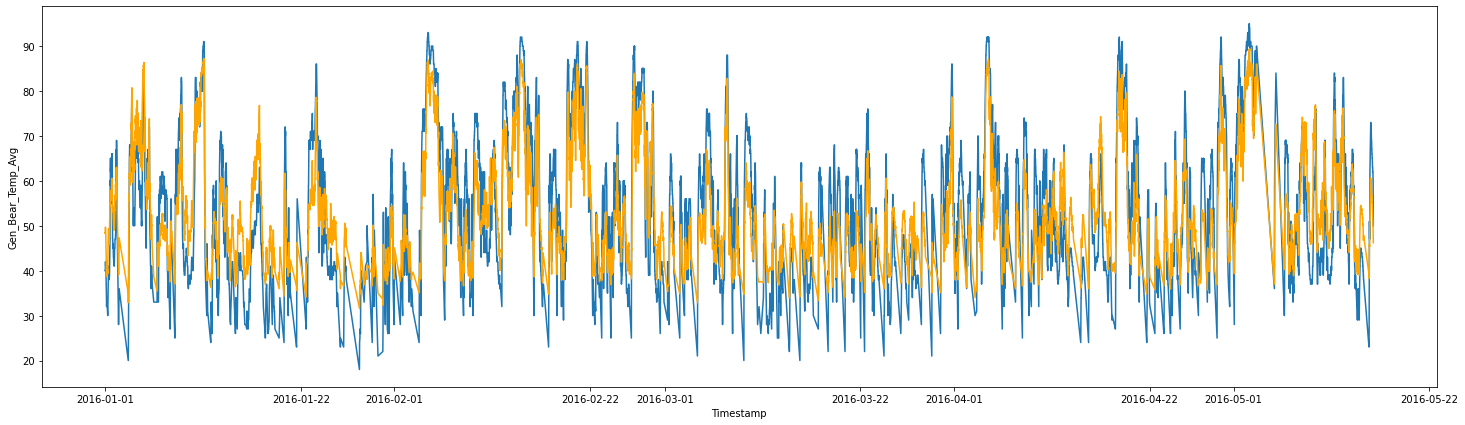

In [ ]:
plt.figure(figsize=(25,7))
sns.lineplot(x=Y_train_2.index, y=Y_train_2[y_column])
sns.lineplot(x=predictions_train_2.index, y=predictions_train_2[y_column], color='orange')

In [ ]:
anomaly_threshold = errors_train_2[y_column].mean() + 3 * errors_train_2[y_column].std()

Y_test_2['Anomaly'] = errors_test_2[y_column] > anomaly_threshold
Y_train_2['Anomaly'] = errors_train_2[y_column] > anomaly_threshold

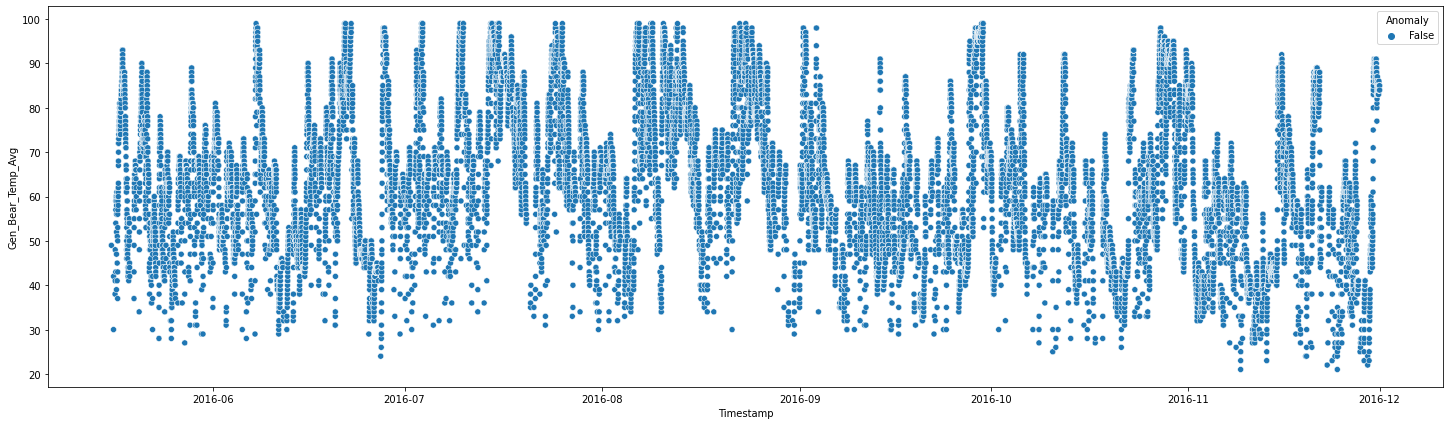

In [ ]:
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_2.reset_index())

In [ ]:
#Alarms
Y_test_2[Y_test_2['Anomaly']]

Empty DataFrame
Columns: [Gen_Bear_Temp_Avg, Anomaly]
Index: []

In [ ]:
Y_train_2[Y_train_2['Anomaly']]

Empty DataFrame
Columns: [Gen_Bear_Temp_Avg, Anomaly]
Index: []

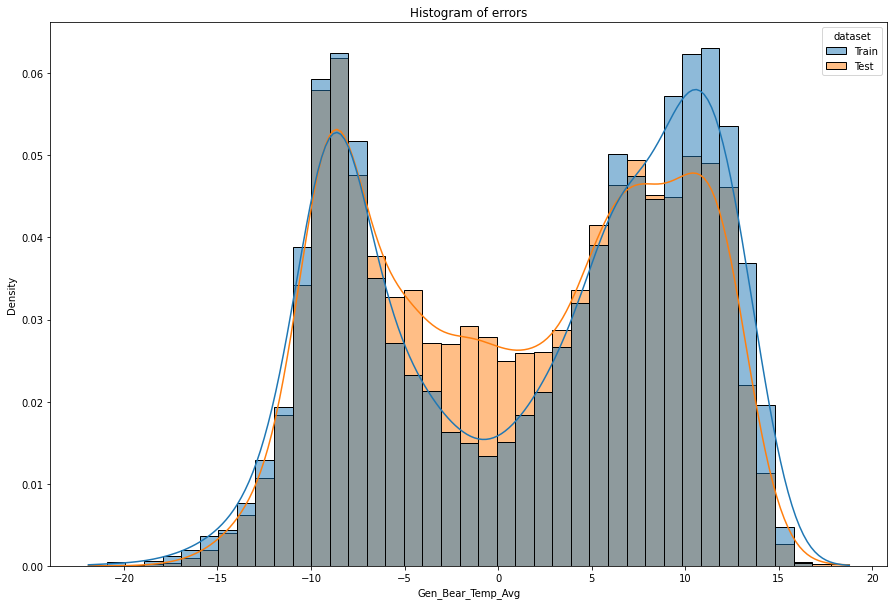

In [ ]:
#Distribution of errors
fig = plt.figure(figsize=(15,10))
errors_train_2['dataset'] = 'Train'
errors_test_2['dataset'] = 'Test'
ax=sns.histplot(pd.concat([errors_train_2, errors_test_2], ignore_index=True), x=y_column, hue='dataset', kde=True, stat='density', common_norm=False)
ax.set_title('Histogram of errors');

Text(0, 0.5, 'Gen Bearing Temp Error [0C]')

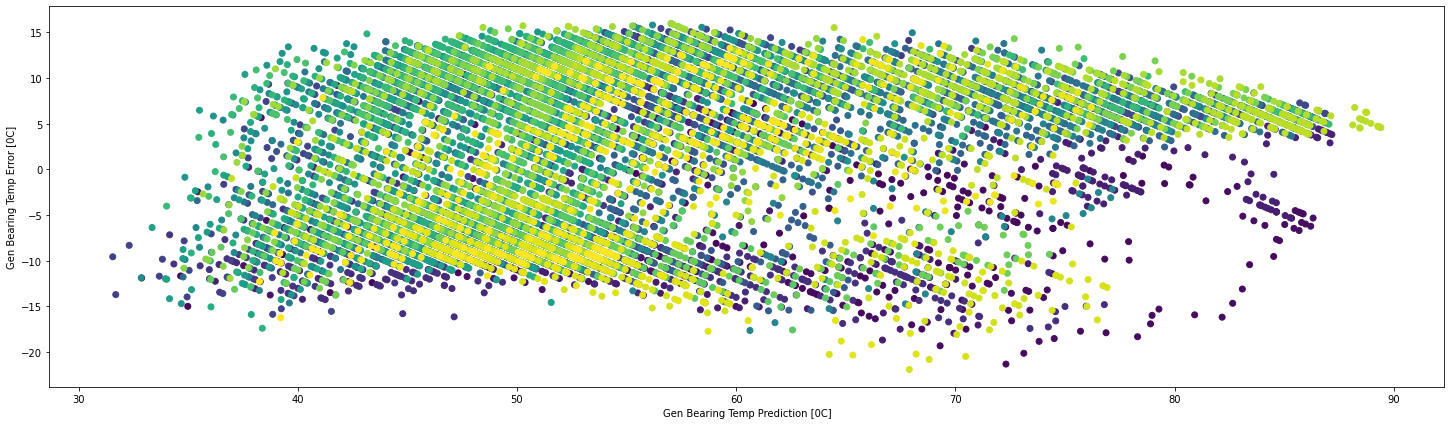

In [ ]:
#Error vs target
fig = plt.figure(figsize=(25,7))
plt.scatter(predictions_train_2[y_column], errors_train_2[y_column], c=[i for i in range(errors_train_2.shape[0])])
plt.xlabel('Gen Bearing Temp Prediction [0C]')
plt.ylabel('Gen Bearing Temp Error [0C]')

In [ ]:
X_train_neg_err = X_train_2[(errors_train_2['Gen_Bear_Temp_Avg'] < -7) & (errors_train_2['Gen_Bear_Temp_Avg'] > -10)]
Y_train_neg_err = Y_train_2[(errors_train_2['Gen_Bear_Temp_Avg'] < -7) & (errors_train_2['Gen_Bear_Temp_Avg'] > -10)]

pred_train_neg_err = predictions_train_2[(errors_train_2['Gen_Bear_Temp_Avg'] < -7) & (errors_train_2['Gen_Bear_Temp_Avg'] > -10)]

In [ ]:
Y_train_neg_err = pd.merge_asof(Y_train_neg_err, log_data_T06['Remark'], left_index = True, right_index = True, tolerance = pd.Timedelta('10m'))

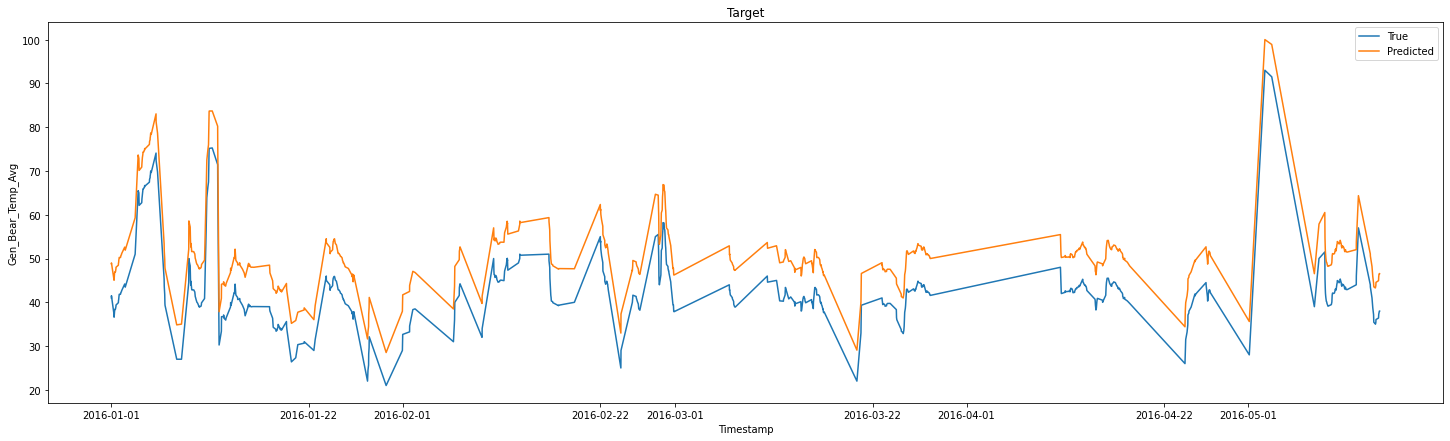

In [ ]:
plt.figure(figsize=(25,7))
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=Y_train_neg_err.rolling('1D').mean())
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=pred_train_neg_err.rolling('1D').mean())
ax.set_title('Target');
ax.legend(['True', 'Predicted'])

In [ ]:
X_train_pos_err = X_train_2[(errors_train_2['Gen_Bear_Temp_Avg'] > 7) & (errors_train_2['Gen_Bear_Temp_Avg'] < 10)]
Y_train_pos_err = Y_train_2[(errors_train_2['Gen_Bear_Temp_Avg'] > 7) & (errors_train_2['Gen_Bear_Temp_Avg'] < 10)]

pred_train_pos_err = predictions_train_2[(errors_train_2['Gen_Bear_Temp_Avg'] > 7) & (errors_train_2['Gen_Bear_Temp_Avg'] < 10)]


In [ ]:
Y_train_pos_err = pd.merge_asof(Y_train_pos_err, log_data_T06['Remark'], left_index = True, right_index = True, tolerance = pd.Timedelta('10m'))

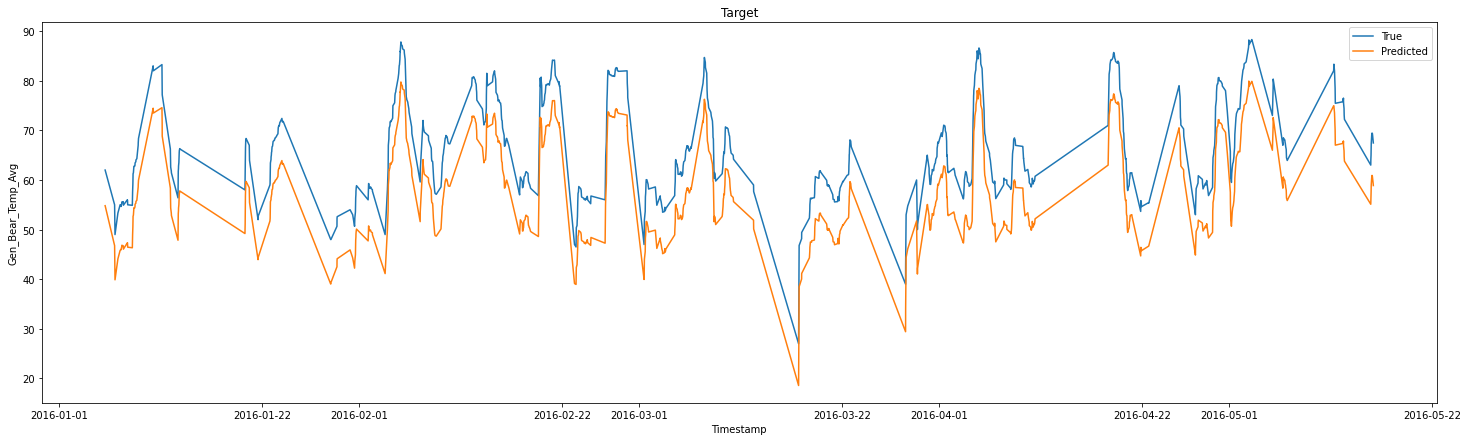

In [ ]:
plt.figure(figsize=(25,7))
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=Y_train_pos_err.rolling('1D').mean())
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=pred_train_pos_err.rolling('1D').mean())
ax.set_title('Target');
ax.legend(['True', 'Predicted'])

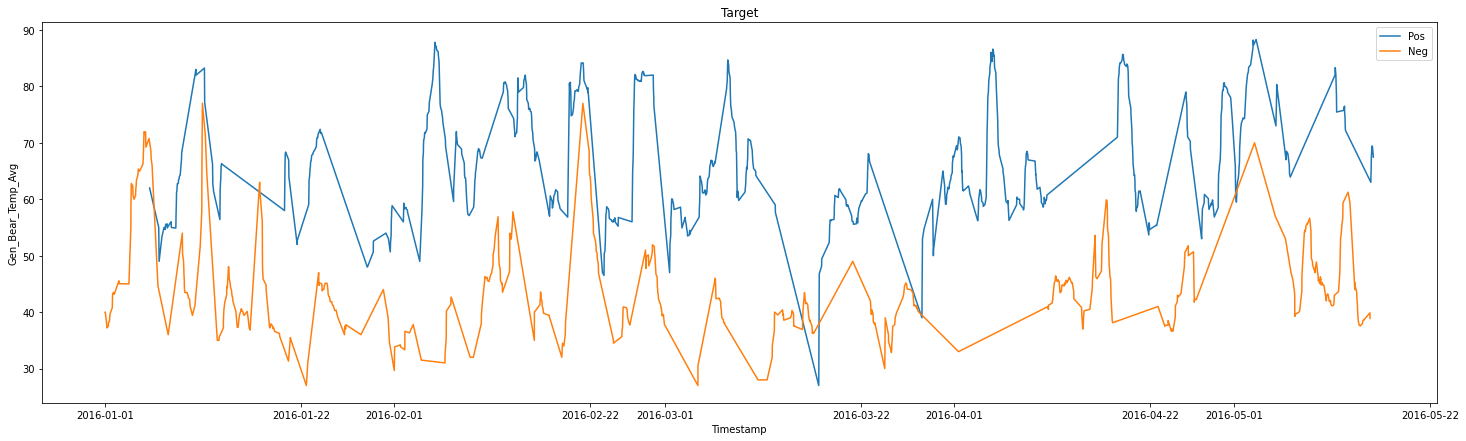

In [ ]:
plt.figure(figsize=(25,7))
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=Y_train_pos_err.rolling('1D').mean())
ax = sns.lineplot(x='Timestamp', y='Gen_Bear_Temp_Avg', data=Y_train_neg_err.rolling('1D').mean())
ax.set_title('Target');
ax.legend(['Pos', 'Neg'])

In [ ]:
Y_train_pos_err['err'] = 'pos'
Y_train_neg_err['err'] = 'neg'
Y_train_err = pd.concat([Y_train_pos_err, Y_train_neg_err], ignore_index=True)

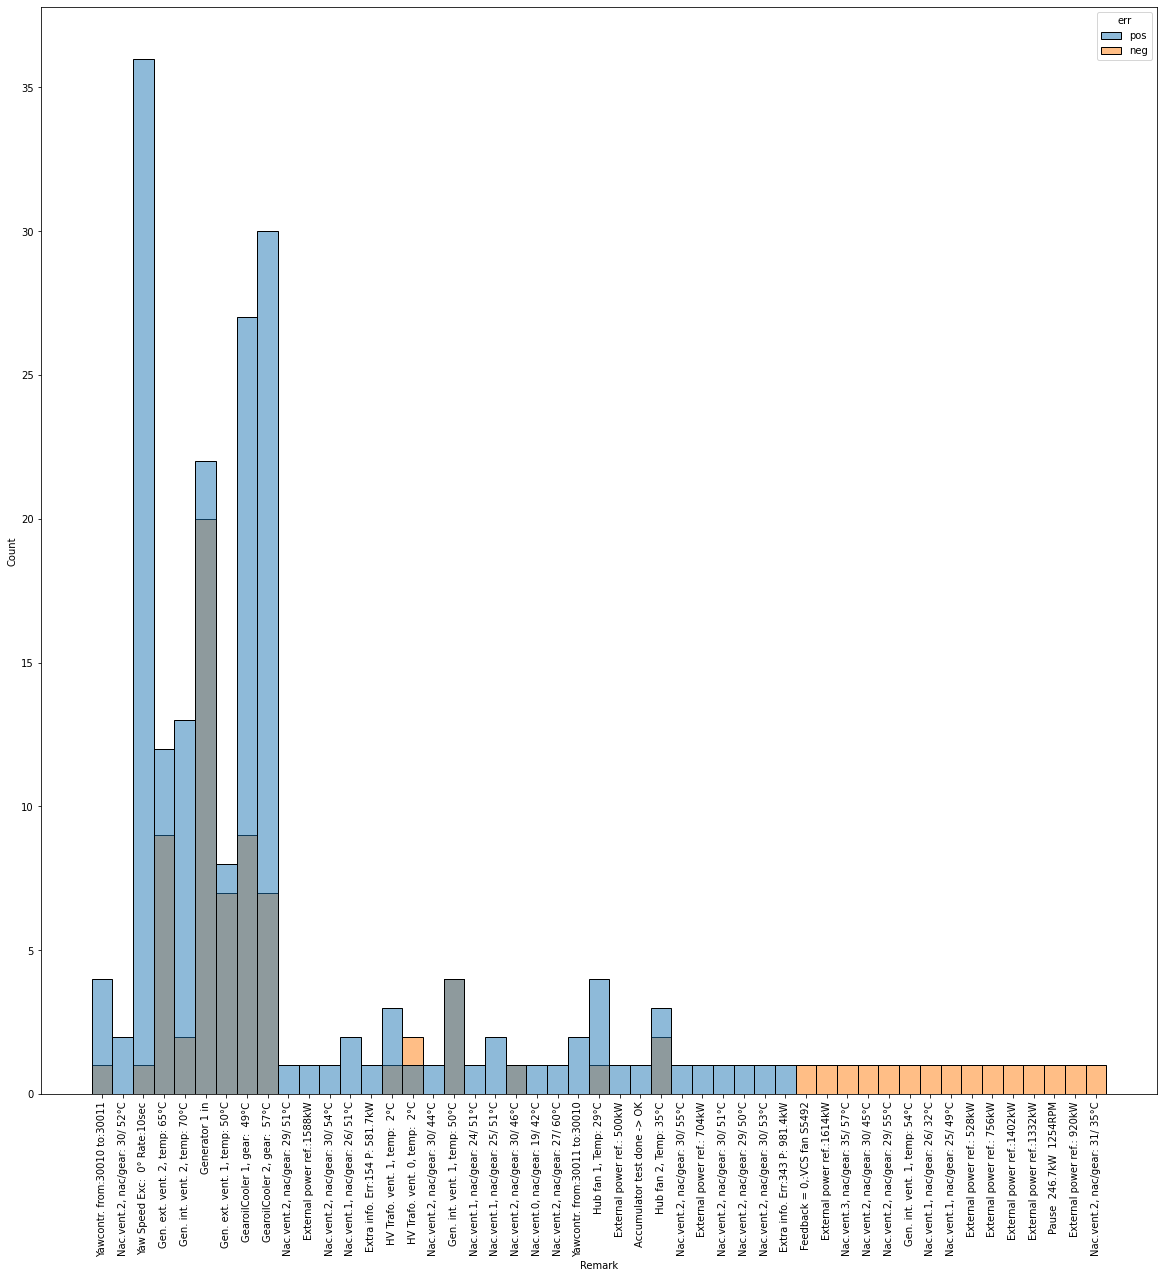

In [ ]:
plt.figure(figsize=(20,20))
sns.histplot(data=Y_train_err[Y_train_err['Remark'] != 'External power ref.:2000kW'], x='Remark', hue='err')
plt.xticks(rotation=90);

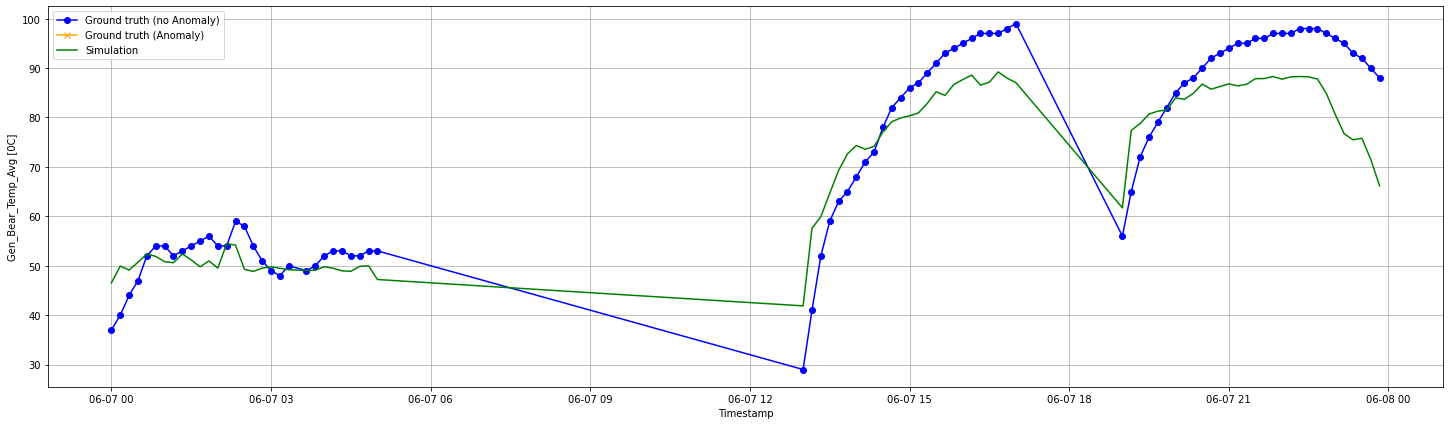

In [ ]:
#Failure 1: June 7, 2016 4:59 PM High temperature generator bearing
X_fail_2 = X_test_2.loc['2016-06-07':'2016-06-07']
Y_fail_2 = Y_test_2.loc['2016-06-07':'2016-06-07']
x_fail_2 = scaler_input.transform(X_fail_2)

plot_predicted_vs_true(pd.DataFrame(scaler_target.inverse_transform(model_2.predict(x_fail_2)), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column, hue='Anomaly')
#plot_error(pd.DataFrame(model_2.predict(X_fail_2), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column)

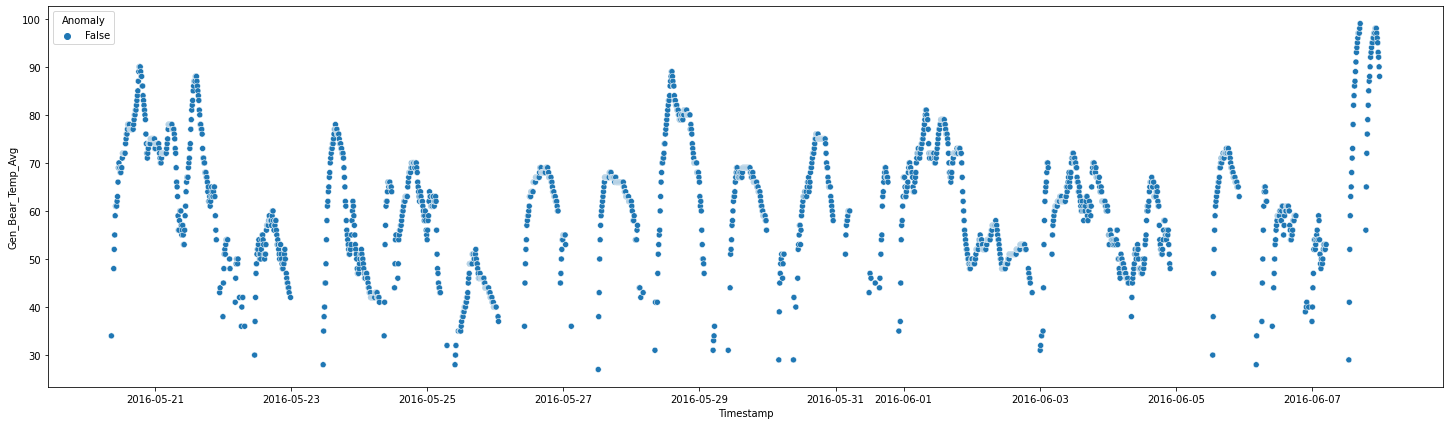

In [ ]:
#Before failure
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_2['2016-05-20':'2016-06-07'].reset_index())

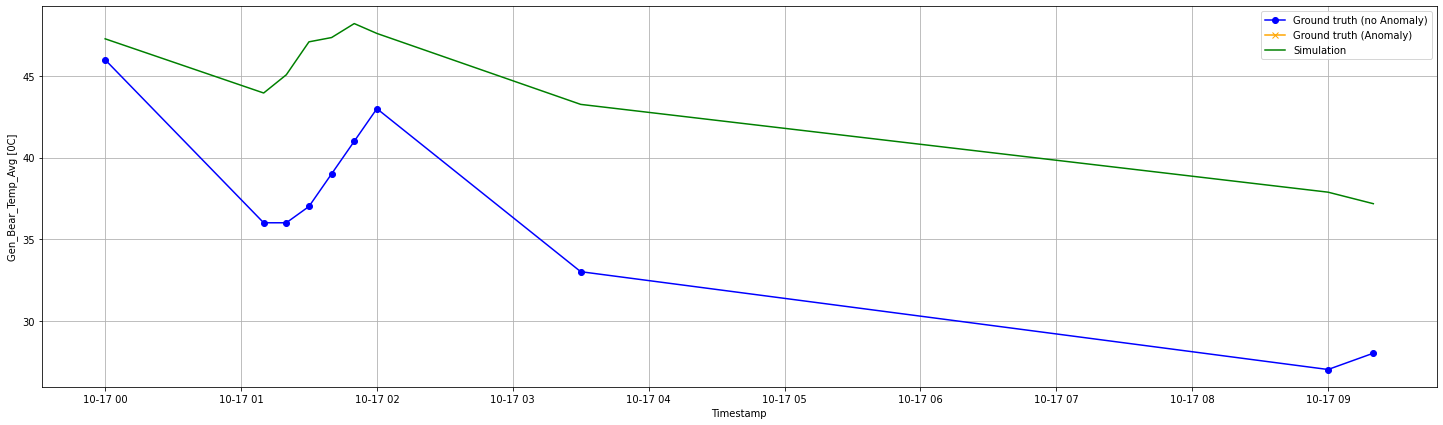

In [ ]:
#Failure 2: October 17, 2016 9:19 AM Generator bearings replaced
X_fail_2 = X_test_2.loc['2016-10-17':'2016-10-17']
Y_fail_2 = Y_test_2.loc['2016-10-17':'2016-10-17']
x_fail_2 = scaler_input.transform(X_fail_2)

plot_predicted_vs_true(pd.DataFrame(scaler_target.inverse_transform(model_2.predict(x_fail_2)), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column, hue='Anomaly')
#plot_error(pd.DataFrame(model_2.predict(X_fail_2), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column)

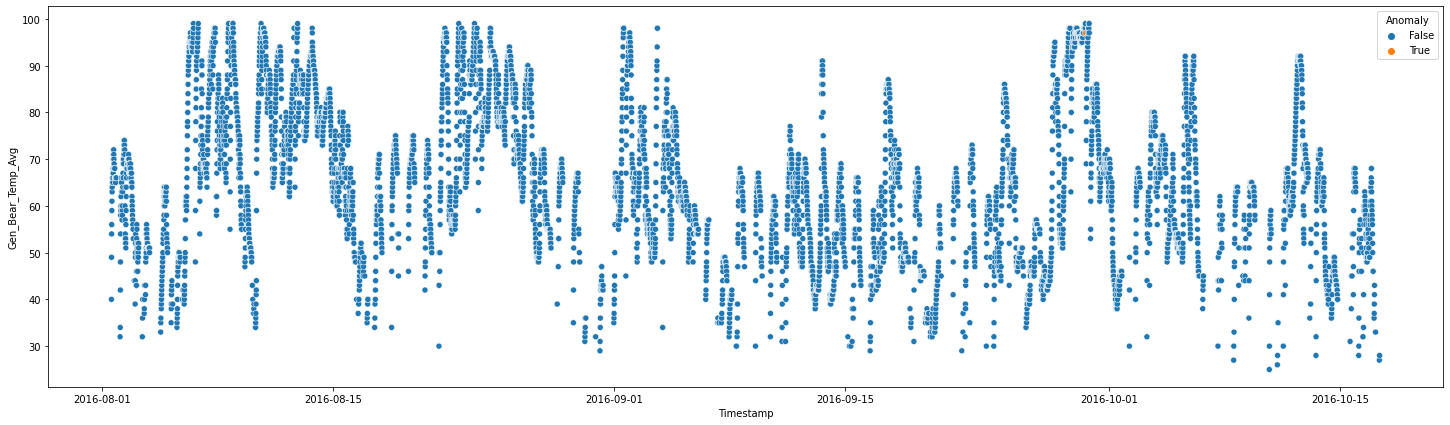

In [ ]:
#Before failure
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_2['2016-08-01':'2016-10-17'].reset_index())

**Compare error distributions of all turbines**

In [ ]:
combined_errors_train_2 = errors_train_2
combined_errors_train_2['turbine_id'] = 'T06'

combined_errors_test_2 = errors_test_2
combined_errors_test_2['turbine_id'] = 'T06'

In [ ]:
for t_id in ['T01', 'T06', 'T07', 'T11']:
  _, _, _, _, errors_train, _, _, _, errors_test, _, _, _ = \
                         implement_pipeline_mlp(all_data, train_date_start = '2016-01-01', train_date_end = '2016-09-30',
                                           test_date_start = '2016-10-01', test_date_end = '2018-01-01', y_column = y_column, turbine_id=t_id,
                         features=features, epochs=200, normalize=True)
  errors_train['turbine_id'] = t_id
  combined_errors_train_2 = pd.concat([combined_errors_train_2, errors_train], ignore_index=True)

  errors_test['turbine_id'] = t_id
  combined_errors_test_2 = pd.concat([combined_errors_test_2, errors_test], ignore_index=True)

Training model...
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 16)                80        
                                                                 
 dropout_25 (Dropout)        (None, 16)                0         
                                                                 
 dense_38 (Dense)            (None, 8)                 136       
                                                                 
 dropout_26 (Dropout)        (None, 8)                 0         
                                                                 
 dense_39 (Dense)            (None, 1)                 9         
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
393/393 - 2s - loss: 0.04

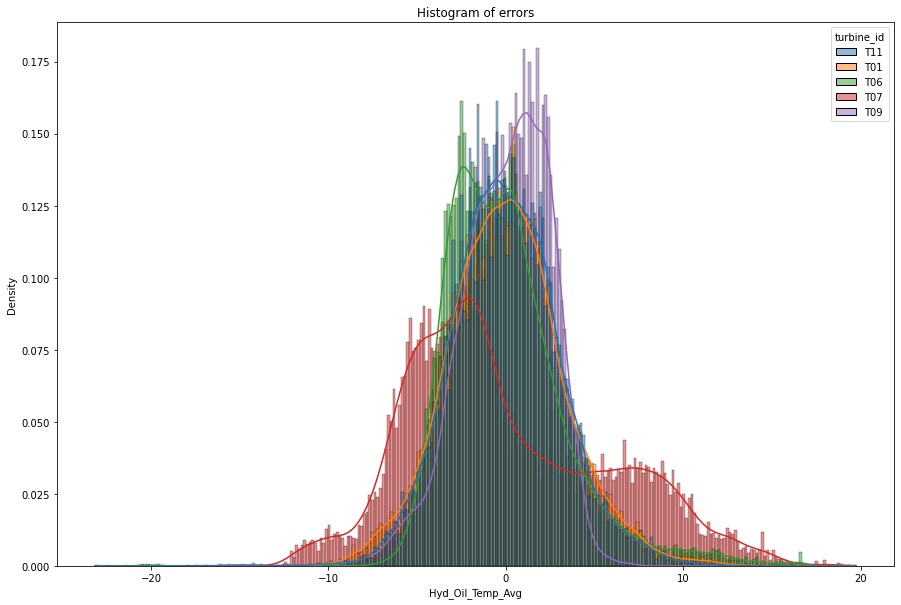

In [ ]:
fig = plt.figure(figsize=(15,10))
ax=sns.histplot(data=combined_errors_train_2, x=y_column, hue='turbine_id', kde=True, stat='density', common_norm=False)
ax.set_title('Histogram of errors');

**LSTM**

**Batch 1:** Train Jan-May, Test Jun-Nov

In [ ]:
dataset_3, X_train_3, Y_train_3, predictions_train_3, errors_train_3, X_test_3, Y_test_3, predictions_test_3, errors_test_3, model_3, scaler_input, scaler_target, x_train_reshaped_3, x_test_reshaped_3 = \
implement_pipeline_LSTM(T06_data, train_date_start = '2016-01-01', train_date_end = '2016-05-15', 
                        test_date_start = '2016-05-16', test_date_end = '2016-11-30', y_column = y_column, turbine_id='T06',
                        features=features, epochs=200, normalize=True, stateful=True, batch_size=100);

Training model...
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (10, 32)                  4864      
                                                                 
 dense_56 (Dense)            (10, 1)                   33        
                                                                 
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________
1271/1271 - 5s - loss: 0.0267 - 5s/epoch - 4ms/step
1271/1271 - 4s - loss: 0.0150 - 4s/epoch - 3ms/step
1271/1271 - 4s - loss: 0.0147 - 4s/epoch - 3ms/step
1271/1271 - 4s - loss: 0.0148 - 4s/epoch - 3ms/step
1271/1271 - 4s - loss: 0.0148 - 4s/epoch - 3ms/step
1271/1271 - 5s - loss: 0.0147 - 5s/epoch - 4ms/step
1271/1271 - 4s - loss: 0.0146 - 4s/epoch - 3ms/step
1271/1271 - 4s - loss: 0.0144 - 4s/epoch - 3ms/step
1271/1271 - 4

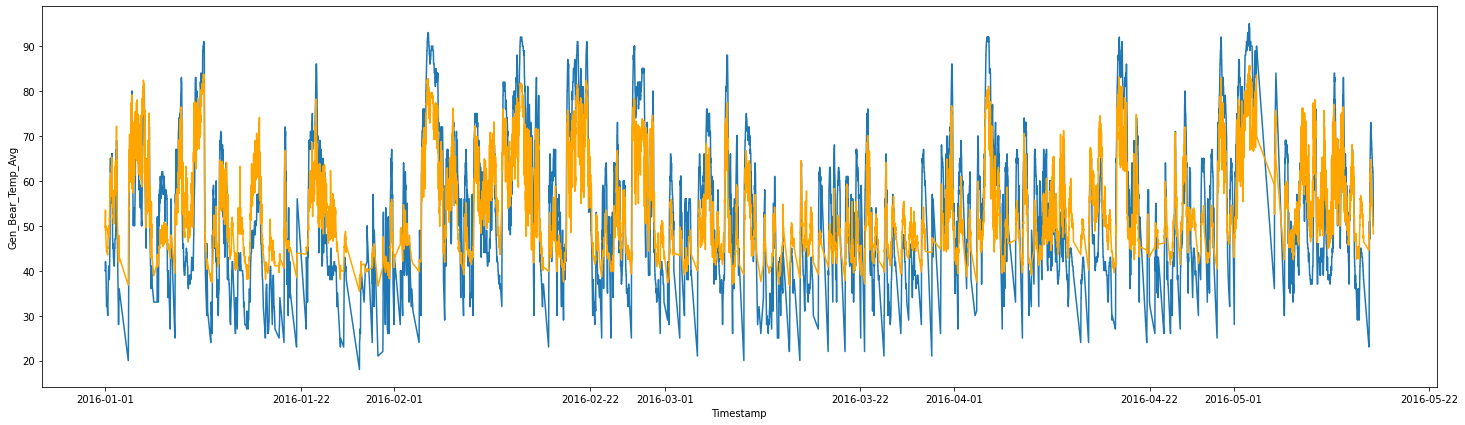

In [ ]:
plt.figure(figsize=(25,7))
sns.lineplot(x=Y_train_3.index, y=Y_train_3[y_column])
sns.lineplot(x=predictions_train_3.index, y=predictions_train_3[y_column], color='orange')

In [ ]:
Y_test_3['Anomaly'] = errors_test_3[y_column] > (errors_test_3[y_column].mean() + 3 * errors_test_3[y_column].std())

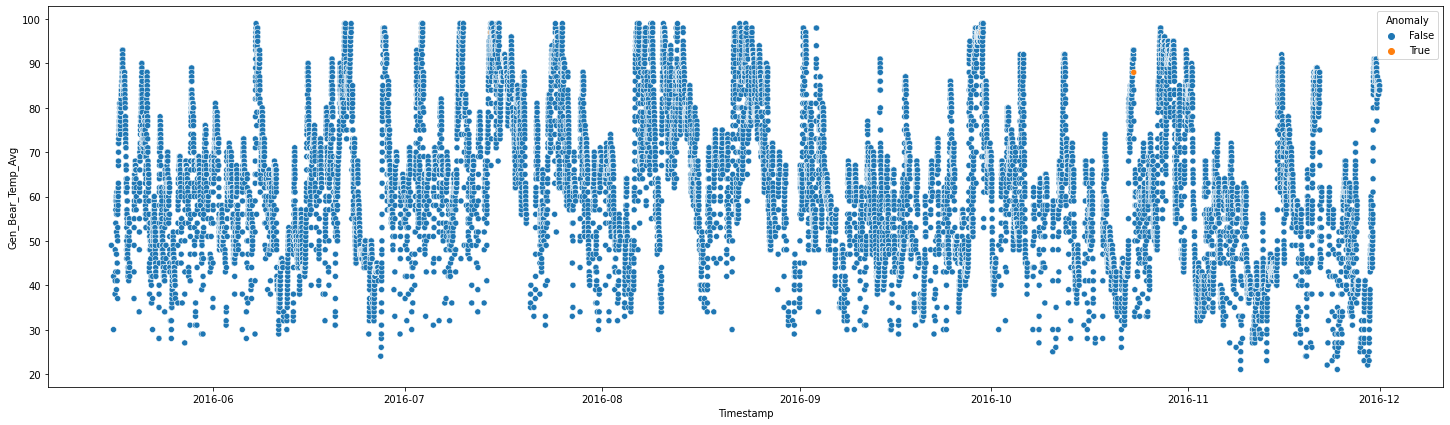

In [ ]:
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_3.reset_index())

In [ ]:
Y_test_3[Y_test_3.Anomaly]

Gen_Bear_Temp_Avg  Anomaly
Timestamp                                            
2016-06-21 16:30:00+00:00               97.0     True
2016-07-03 17:20:00+00:00               97.0     True
2016-07-14 12:50:00+00:00               97.0     True
2016-09-29 13:40:00+00:00               97.0     True
2016-10-23 10:10:00+00:00               88.0     True

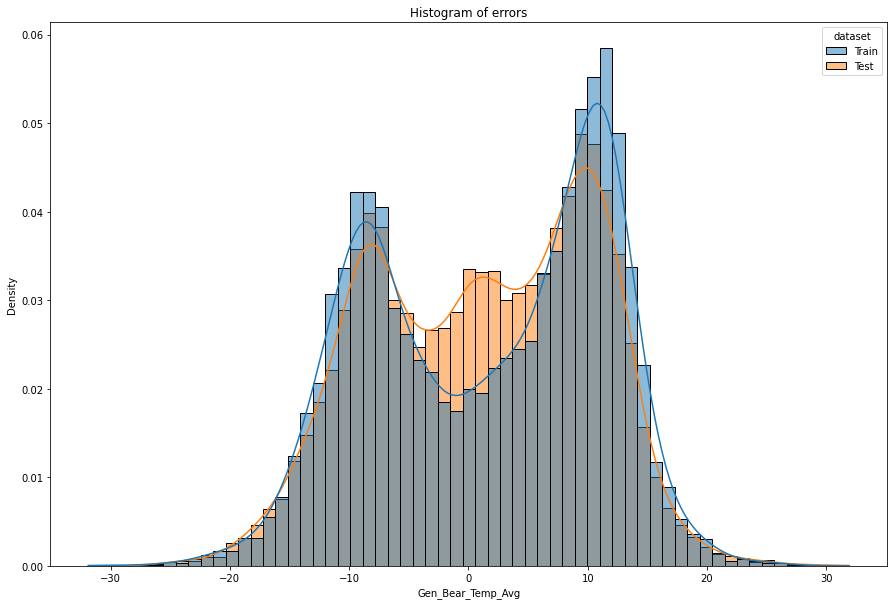

In [ ]:
#Distribution of errors
fig = plt.figure(figsize=(15,10))
errors_train_3['dataset'] = 'Train'
errors_test_3['dataset'] = 'Test'
ax=sns.histplot(pd.concat([errors_train_3, errors_test_3], ignore_index=True), x=y_column, hue='dataset', kde=True, stat='density', common_norm=False)
ax.set_title('Histogram of errors');

Text(0, 0.5, 'Gen Bear Temp Error [0C]')

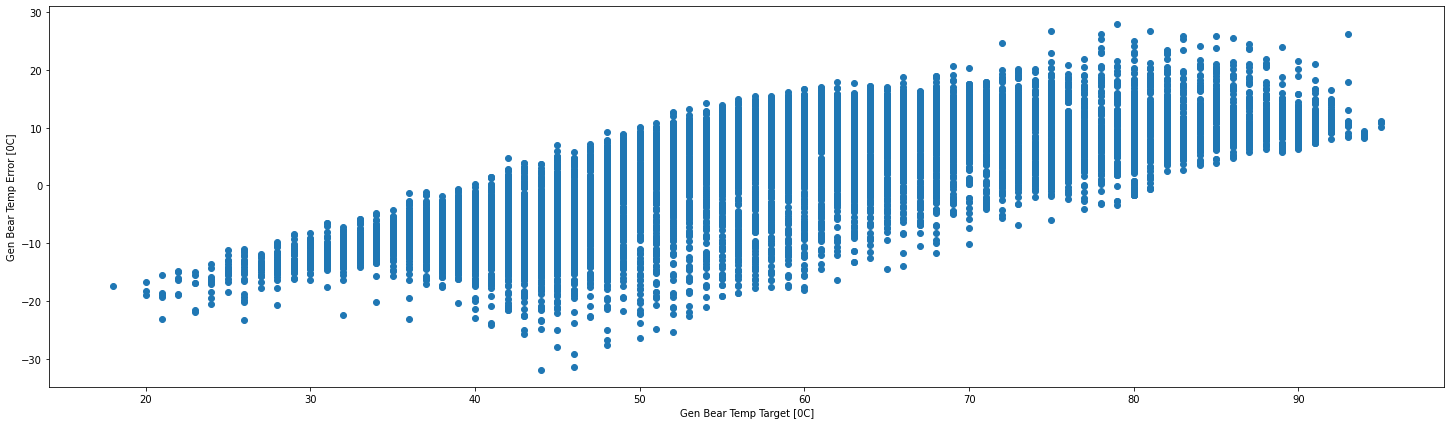

In [ ]:
#Error vs target
fig = plt.figure(figsize=(25,7))
plt.scatter(Y_train_3[y_column], errors_train_3[y_column])
plt.xlabel('Gen Bear Temp Target [0C]')
plt.ylabel('Gen Bear Temp Error [0C]')

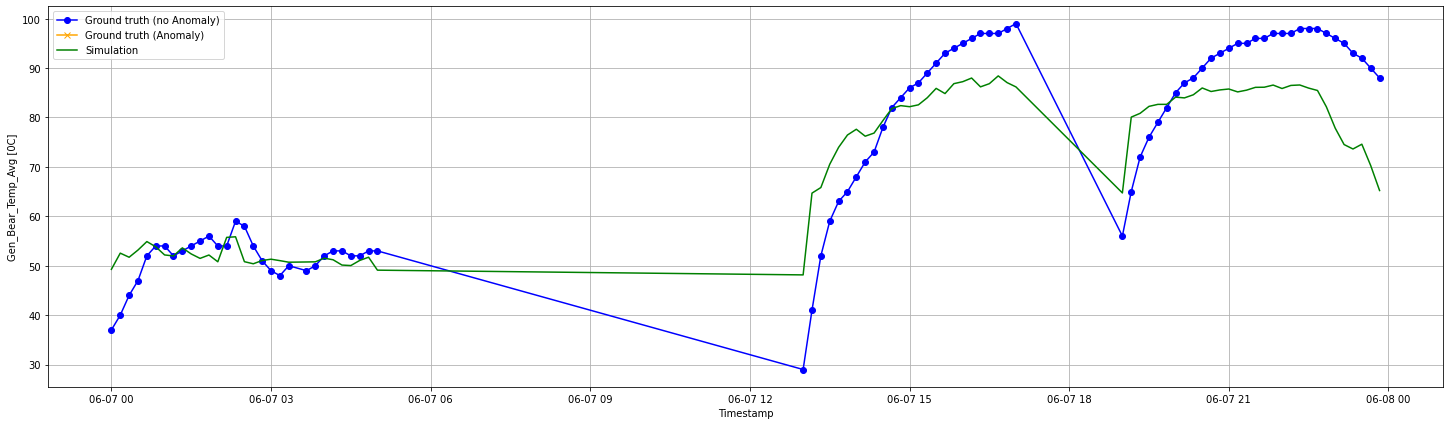

In [ ]:
#Failure 1: June 7, 2016 4:59 PM High temperature generator bearing
X_fail_1 = X_test_3.loc['2016-06-07':'2016-06-07']
Y_fail_1 = Y_test_3.loc['2016-06-07':'2016-06-07']
x_fail_1 = np.array(scaler_input.transform(X_fail_1)).reshape(x_fail_1.shape[0], 1, x_fail_1.shape[1])

plot_predicted_vs_true(pd.DataFrame(scaler_target.inverse_transform(model_3.predict(x_fail_1)), columns=[y_column], index=X_fail_1.index),Y_fail_1, y_column, hue='Anomaly')
#plot_error(pd.DataFrame(model_1.predict(X_fail_1), columns=[y_column], index=X_fail_1.index),Y_fail_1, y_column)

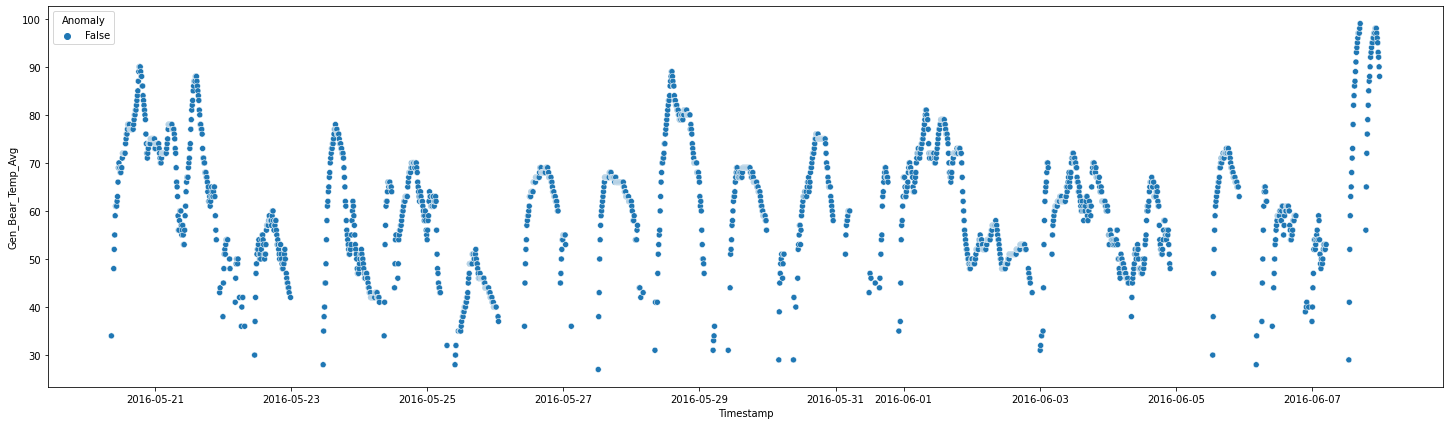

In [ ]:
#Before failure
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_3['2016-05-20':'2016-06-07'].reset_index())

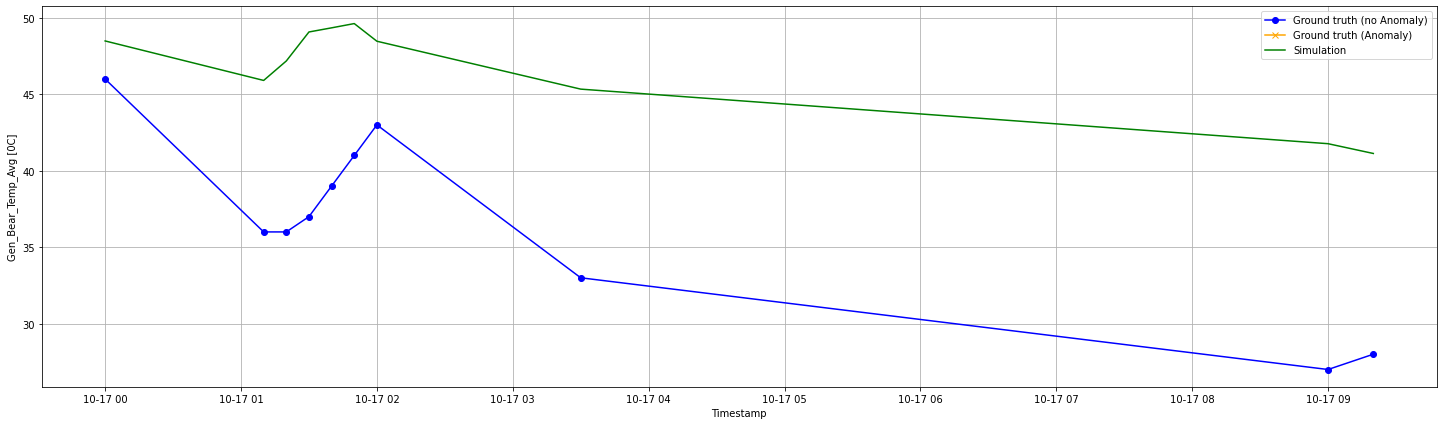

In [ ]:
#Failure 2: October 17, 2016 9:19 AM Generator bearings replaced
X_fail_ = X_test_3.loc['2016-10-17':'2016-10-17']
Y_fail_2 = Y_test_3.loc['2016-10-17':'2016-10-17']
x_fail_2 = np.array(scaler_input.transform(X_fail_2)).reshape(x_fail_2.shape[0], 1, x_fail_2.shape[1])

plot_predicted_vs_true(pd.DataFrame(scaler_target.inverse_transform(model_3.predict(x_fail_2)), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column, hue='Anomaly')
#plot_error(pd.DataFrame(model_1.predict(X_fail_2), columns=[y_column], index=X_fail_2.index),Y_fail_2, y_column)

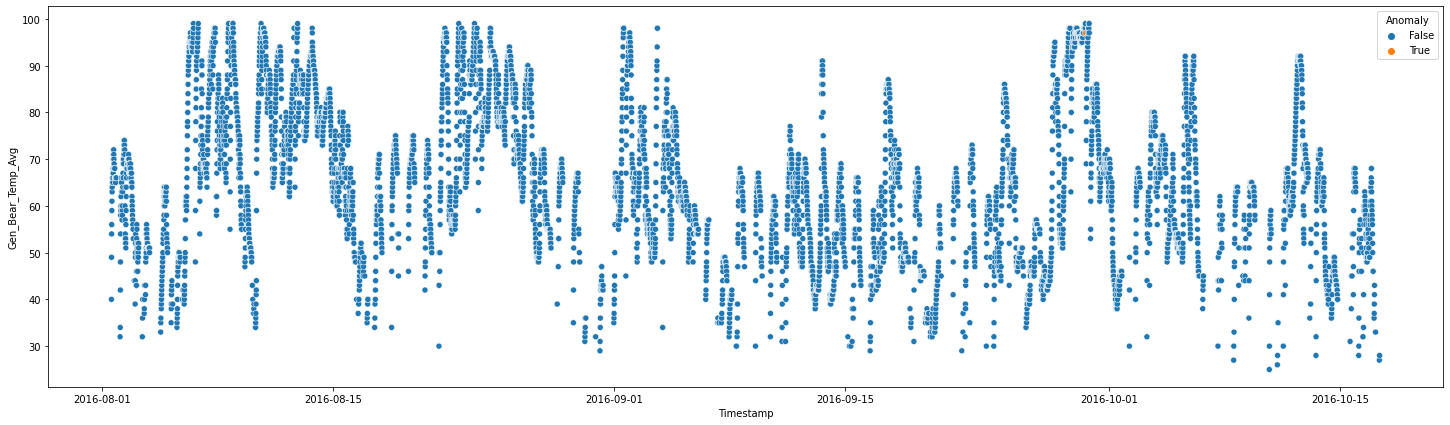

In [ ]:
#Before failure
fig = plt.figure(figsize=(25,7))
sns.scatterplot(x='Timestamp', y=y_column, hue='Anomaly', data=Y_test_3['2016-08-01':'2016-10-17'].reset_index())

**Compare error distributions of all turbines**

In [ ]:
combined_errors_train_2 = errors_train_2
combined_errors_train_2['turbine_id'] = 'T06'

combined_errors_test_2 = errors_test_2
combined_errors_test_2['turbine_id'] = 'T06'

In [ ]:
for t_id in ['T01', 'T06', 'T07', 'T06']:
  _, _, _, _, errors_train, _, _, _, errors_test, _, _, _ = \
                         implement_pipeline_mlp(all_data, train_date_start = '2016-01-01', train_date_end = '2016-09-30',
                                           test_date_start = '2016-10-01', test_date_end = '2018-01-01', y_column = y_column, turbine_id=t_id,
                         features=features, epochs=200, normalize=True)
  errors_train['turbine_id'] = t_id
  combined_errors_train_2 = pd.concat([combined_errors_train_2, errors_train], ignore_index=True)

  errors_test['turbine_id'] = t_id
  combined_errors_test_2 = pd.concat([combined_errors_test_2, errors_test], ignore_index=True)

In [ ]:
fig = plt.figure(figsize=(15,10))
ax=sns.histplot(data=combined_errors_train_2, x=y_column, hue='turbine_id', kde=True, stat='density', common_norm=False)
ax.set_title('Histogram of errors');